In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys
import math

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy

import datetime as dt
import statsmodels.api as sm
import scipy.stats as stats
import decimal

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#### Import Sample Annotation file for filtered *longitudinal* isolates pairs

In [3]:
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep  = ',').set_index('patient_id')

In [4]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


#################################################################################################################################################################################################################################

## [1] Collect all AR nSNPs with $\Delta AF \ge 5\%$ (in genes & intergenic regions associated with antibiotic resistance)

#################################################################################################################################################################################################################################

#### Load in filtered Base Calls from longitudinal Base Call analysis (pairs of Base Calls that are different subjects, filtered for low coverage have a difference in Alternate Allele Frequency $\ge 5\%$)

The DataFrame below will consist of two rows per in-host SNP, corresponding to the 1st and 2nd alternate allele frequencies.

In [87]:
within_host_Base_Call_variants_all_patients = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/longitudinal_SNP_variants_05_delta_in_alt_AF.pkl')

In [88]:
within_host_Base_Call_variants_all_patients.head(n=10)

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change
0,G,T,55540,10521,Ref_PASS,[],"{u'QP': [0, 0, 95, 5], u'AC': [0], u'BC': [0, ...",0.05,350,Peru5118,CETR,2049,Rv0050,1878,Non-Essential,ponA1,S,P626P
1,G,T,55540,2494,Ref_PASS,[],"{u'QP': [0, 0, 88, 12], u'AC': [0], u'BC': [0,...",0.12,129,Peru4678,CETR,2049,Rv0050,1878,Non-Essential,ponA1,S,P626P
2,G,C,333556,4775,Ref_PASS,[],"{u'QP': [0, 6, 94, 0], u'AC': [0], u'BC': [0, ...",0.06,169,Peru4678,CETR,2049,Rv0278c,2755,PE/PPE,PE_PGRS3,N,R919G
3,G,C,333556,7928,Ref_PASS,[],"{u'QP': [0, 11, 89, 0], u'AC': [0], u'BC': [1,...",0.11,359,Peru5118,CETR,2049,Rv0278c,2755,PE/PPE,PE_PGRS3,N,R919G
4,G,C,333562,4570,Ref_PASS,[],"{u'QP': [0, 7, 93, 0], u'AC': [0], u'BC': [0, ...",0.07,172,Peru4678,CETR,2049,Rv0278c,2749,PE/PPE,PE_PGRS3,N,R917G
5,G,C,333562,7115,Ref_PASS,[],"{u'QP': [0, 13, 87, 0], u'AC': [0], u'BC': [0,...",0.13,375,Peru5118,CETR,2049,Rv0278c,2749,PE/PPE,PE_PGRS3,N,R917G
6,G,C,333569,4363,Ref_PASS,[],"{u'QP': [0, 7, 93, 0], u'AC': [0], u'BC': [0, ...",0.07,171,Peru4678,CETR,2049,Rv0278c,2742,PE/PPE,PE_PGRS3,S,G914G
7,G,C,333569,6637,Ref_PASS,[],"{u'QP': [0, 13, 87, 0], u'AC': [0], u'BC': [0,...",0.13,374,Peru5118,CETR,2049,Rv0278c,2742,PE/PPE,PE_PGRS3,S,G914G
8,C,G,333571,6489,Ref_PASS,[],"{u'QP': [0, 86, 14, 0], u'AC': [0], u'BC': [1,...",0.14,379,Peru5118,CETR,2049,Rv0278c,2740,PE/PPE,PE_PGRS3,N,G914R
9,C,G,333571,4288,Ref_PASS,[],"{u'QP': [0, 92, 8, 0], u'AC': [0], u'BC': [0, ...",0.08,174,Peru4678,CETR,2049,Rv0278c,2740,PE/PPE,PE_PGRS3,N,G914R


In [89]:
np.shape(within_host_Base_Call_variants_all_patients)

(1301546, 18)

### *Filter 1*: Filter out paired Base Calls if (minor allele has less than 5 reads supporting it) and ($\Delta AF$ < 20%)

In [90]:
#list that stores the DataFrame indices of all SNPs that don't pass Delta AF threshold
BaseCalls_to_Drop = []

#dictionary for ordering of bases in Base Counts field
base_order_dict = {'A':0 , 'C':1 , 'G':2 , 'T':3}

delta_AF_threshold = 0.20

#for each pair of Base Calls,
for Base_Call_A_index , Base_Call_B_index in zip( range(0 , np.shape(within_host_Base_Call_variants_all_patients)[0] , 2) , range(1 , np.shape(within_host_Base_Call_variants_all_patients)[0] , 2) ):
    
    ############################################################################################################################################
    #get relevant info for the Base Calls corresponding to both isolates
    Base_Call_isolate_A_data = within_host_Base_Call_variants_all_patients.loc[Base_Call_A_index , :]
    Base_Call_isolate_B_data = within_host_Base_Call_variants_all_patients.loc[Base_Call_B_index , :]
        
    #pull BC 'field' (base count in pileups at for each isolates in the pair)
    Base_Call_isolate_A_base_counts = Base_Call_isolate_A_data['INFO']['BC']
    Base_Call_isolate_B_base_counts = Base_Call_isolate_B_data['INFO']['BC']
    
    #pull QP 'field' (quality-percentage in pileups supporting each base; for each isolate in the pair)
    Base_Call_isolate_A_QP = Base_Call_isolate_A_data['INFO']['QP']
    Base_Call_isolate_B_QP = Base_Call_isolate_B_data['INFO']['QP']
    
    #get reference and alternate alleles for both isolates
    
    #reference alleles
    isolate_A_ref_allele = Base_Call_isolate_A_data['ref_base']
    isolate_B_ref_allele = Base_Call_isolate_B_data['ref_base']
    
    #alternate alleles (if there are any)
    isolate_A_alt_allele = Base_Call_isolate_A_data['alt_base']
    isolate_B_alt_allele = Base_Call_isolate_B_data['alt_base']
    
    #get the RAW NUMBER OF READS supporting each allele (ref alleles for isolates A & B and possibly alt alleles for isolates A & B)
    
    #reference allele counts
    isolate_A_ref_allele_read_counts = Base_Call_isolate_A_base_counts[base_order_dict[isolate_A_ref_allele]]
    isolate_B_ref_allele_read_counts = Base_Call_isolate_B_base_counts[base_order_dict[isolate_B_ref_allele]]
    
    #alternate allele counts
    if isolate_A_alt_allele != 'Z':
        isolate_A_alt_allele_read_counts = Base_Call_isolate_A_base_counts[base_order_dict[isolate_A_alt_allele]]
    elif isolate_A_alt_allele == 'Z':
        isolate_A_alt_allele_read_counts = 0

    if isolate_B_alt_allele != 'Z':
        isolate_B_alt_allele_read_counts = Base_Call_isolate_B_base_counts[base_order_dict[isolate_B_alt_allele]]
    elif isolate_B_alt_allele == 'Z':
        isolate_B_alt_allele_read_counts = 0
        
    #get the WEIGHTED PERCENTAGE OF READS supporting each allele (ref alleles for isolates A & B and possibly alt alleles for isolates A & B)
    
    #reference allele weighted %
    isolate_A_ref_allele_QP = Base_Call_isolate_A_QP[base_order_dict[isolate_A_ref_allele]]
    isolate_B_ref_allele_QP = Base_Call_isolate_B_QP[base_order_dict[isolate_B_ref_allele]]
    
    #alternate allele weighted %
    if isolate_A_alt_allele != 'Z':
        isolate_A_alt_allele_QP = Base_Call_isolate_A_QP[base_order_dict[isolate_A_alt_allele]]
    elif isolate_A_alt_allele == 'Z':
        isolate_A_alt_allele_QP = 0

    if isolate_B_alt_allele != 'Z':
        isolate_B_alt_allele_QP = Base_Call_isolate_B_QP[base_order_dict[isolate_B_alt_allele]]
    elif isolate_B_alt_allele == 'Z':
        isolate_B_alt_allele_QP = 0
    ############################################################################################################################################
    
    #pull Alterante AF for the base calls corresponding to each isolates in a serial pair
    Base_Call_isolate_A_alt_AF = within_host_Base_Call_variants_all_patients.loc[Base_Call_A_index , 'alt_AF']
    Base_Call_isolate_B_alt_AF = within_host_Base_Call_variants_all_patients.loc[Base_Call_B_index , 'alt_AF'] 
    
    #calculate the difference of the Alternate Allele Frequencies of both serial isolates
    delta_AF = abs(Base_Call_isolate_B_alt_AF - Base_Call_isolate_A_alt_AF)
    
    ############################################################################################################################################
    
    #make sure at least 5 reads supports each allele if the call is mixed (that is some reads support the reference and some support the alternate)
    ## if one allele has 0 reads supporting it, whether its the reference or alternate, the other allele should have at least 25 reads supporting it (min depth)
    #print str(isolate_A_ref_allele_QP) + ' ' + str(isolate_A_ref_allele_read_counts) + ' ' + str(isolate_A_alt_allele_QP) + ' ' + str(isolate_A_alt_allele_read_counts)
    
    #if either allele has QP > 0, then it should have at least 5 reads supporting that percentage
    #if reads support allele for at least 1%, then there should be at least 5 reads supporting that allele
    if ( ( (isolate_A_ref_allele_QP > 0) and (isolate_A_ref_allele_read_counts < 5) ) or ( (isolate_A_alt_allele_QP > 0) and (isolate_A_alt_allele_read_counts < 5) ) ) and (delta_AF < delta_AF_threshold):
        
        
        #minor allele in mixed call had less than 5 reads supporting, drop base calls corresponding to BOTH isolates
        BaseCalls_to_Drop.append(Base_Call_A_index)
        BaseCalls_to_Drop.append(Base_Call_B_index)
            
    elif ( ( (isolate_B_ref_allele_QP > 0) and (isolate_B_ref_allele_read_counts < 5) ) or ( (isolate_B_alt_allele_QP > 0) and (isolate_B_alt_allele_read_counts < 5) ) ) and (delta_AF < delta_AF_threshold):
        
        #minor allele in mixed call had less than 5 reads supporting, drop base calls corresponding to BOTH isolates
        BaseCalls_to_Drop.append(Base_Call_A_index)
        BaseCalls_to_Drop.append(Base_Call_B_index)
        
within_host_Base_Call_variants_all_patients.drop(labels = BaseCalls_to_Drop , axis = 0 , inplace = True)

#reset index
within_host_Base_Call_variants_all_patients.reset_index(drop = True, inplace = True)

In [91]:
np.shape(within_host_Base_Call_variants_all_patients)

(516328, 18)

In [92]:
within_host_Base_Call_variants_all_patients.head()

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change
0,G,T,55540,10521,Ref_PASS,[],"{u'QP': [0, 0, 95, 5], u'AC': [0], u'BC': [0, ...",0.05,350,Peru5118,CETR,2049,Rv0050,1878,Non-Essential,ponA1,S,P626P
1,G,T,55540,2494,Ref_PASS,[],"{u'QP': [0, 0, 88, 12], u'AC': [0], u'BC': [0,...",0.12,129,Peru4678,CETR,2049,Rv0050,1878,Non-Essential,ponA1,S,P626P
2,G,C,333556,4775,Ref_PASS,[],"{u'QP': [0, 6, 94, 0], u'AC': [0], u'BC': [0, ...",0.06,169,Peru4678,CETR,2049,Rv0278c,2755,PE/PPE,PE_PGRS3,N,R919G
3,G,C,333556,7928,Ref_PASS,[],"{u'QP': [0, 11, 89, 0], u'AC': [0], u'BC': [1,...",0.11,359,Peru5118,CETR,2049,Rv0278c,2755,PE/PPE,PE_PGRS3,N,R919G
4,G,C,333562,4570,Ref_PASS,[],"{u'QP': [0, 7, 93, 0], u'AC': [0], u'BC': [0, ...",0.07,172,Peru4678,CETR,2049,Rv0278c,2749,PE/PPE,PE_PGRS3,N,R917G


### *Filter 2*: Drop Synonymous SNPs (drops sSNPs, retains nSNPs & iSNPs)

In [93]:
#list that stores the DataFrame indices of all SNPs that don't pass Delta AF threshold
BaseCalls_to_Drop = []

#for each pair of Base Calls, store (alternate Allele Frequency of isolate_1) and (alternate Allele Frequency of isolate_2 - alternate Allele Frequency of isolate_1)
for Base_Call_A_index , Base_Call_B_index in zip( range(0 , np.shape(within_host_Base_Call_variants_all_patients)[0] , 2) , range(1 , np.shape(within_host_Base_Call_variants_all_patients)[0] , 2) ):
        
    #pull SNP type
    Base_Call_isolate_A_SNP_type = within_host_Base_Call_variants_all_patients.loc[Base_Call_A_index , 'SNP_ftype']
    Base_Call_isolate_B_SNP_type = within_host_Base_Call_variants_all_patients.loc[Base_Call_B_index , 'SNP_ftype'] 
    
    #put SNP types (for both Base Calls) in a list
    SNP_type_list = [Base_Call_isolate_A_SNP_type , Base_Call_isolate_B_SNP_type]
    
    #if Synonymous SNP, then drop
    if 'S' in SNP_type_list:
        
        BaseCalls_to_Drop.append(Base_Call_A_index)
        BaseCalls_to_Drop.append(Base_Call_B_index)

within_host_Base_Call_variants_all_patients.drop(labels = BaseCalls_to_Drop , axis = 0 , inplace = True)

#reset index
within_host_Base_Call_variants_all_patients.reset_index(drop = True, inplace = True)

In [94]:
within_host_Base_Call_variants_all_patients.head(n=10)

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change
0,G,C,333556,4775,Ref_PASS,[],"{u'QP': [0, 6, 94, 0], u'AC': [0], u'BC': [0, ...",0.06,169,Peru4678,CETR,2049,Rv0278c,2755,PE/PPE,PE_PGRS3,N,R919G
1,G,C,333556,7928,Ref_PASS,[],"{u'QP': [0, 11, 89, 0], u'AC': [0], u'BC': [1,...",0.11,359,Peru5118,CETR,2049,Rv0278c,2755,PE/PPE,PE_PGRS3,N,R919G
2,G,C,333562,4570,Ref_PASS,[],"{u'QP': [0, 7, 93, 0], u'AC': [0], u'BC': [0, ...",0.07,172,Peru4678,CETR,2049,Rv0278c,2749,PE/PPE,PE_PGRS3,N,R917G
3,G,C,333562,7115,Ref_PASS,[],"{u'QP': [0, 13, 87, 0], u'AC': [0], u'BC': [0,...",0.13,375,Peru5118,CETR,2049,Rv0278c,2749,PE/PPE,PE_PGRS3,N,R917G
4,C,G,333571,6489,Ref_PASS,[],"{u'QP': [0, 86, 14, 0], u'AC': [0], u'BC': [1,...",0.14,379,Peru5118,CETR,2049,Rv0278c,2740,PE/PPE,PE_PGRS3,N,G914R
5,C,G,333571,4288,Ref_PASS,[],"{u'QP': [0, 92, 8, 0], u'AC': [0], u'BC': [0, ...",0.08,174,Peru4678,CETR,2049,Rv0278c,2740,PE/PPE,PE_PGRS3,N,G914R
6,G,C,333580,3447,Ref_PASS,[],"{u'QP': [0, 12, 88, 0], u'AC': [0], u'BC': [0,...",0.12,183,Peru4678,CETR,2049,Rv0278c,2731,PE/PPE,PE_PGRS3,N,Q911E
7,G,C,333580,4071,Ref_PASS,[],"{u'QP': [0, 19, 81, 0], u'AC': [0], u'BC': [0,...",0.19,412,Peru5118,CETR,2049,Rv0278c,2731,PE/PPE,PE_PGRS3,N,Q911E
8,T,G,455781,2010,Ref_PASS,[],"{u'QP': [0, 0, 10, 90], u'AC': [0], u'BC': [0,...",0.10,104,Peru4678,CETR,2049,Rv0378,145,Non-Essential,NaN,N,S49A
9,T,G,455781,8350,Ref_PASS,[],"{u'QP': [0, 0, 4, 96], u'AC': [0], u'BC': [2, ...",0.04,307,Peru5118,CETR,2049,Rv0378,145,Non-Essential,NaN,N,S49A


In [95]:
np.shape(within_host_Base_Call_variants_all_patients)

(396458, 18)

### *Filter 3*: Subset to loci known to be associated with resistance to antibiotics

#### Loci associated with Antibiotic Resistance (N = 28 genes) + (N = 6 intergenic regions) + (N = 1 rRNA)

In [96]:
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')
antibiotic_resistance_genes = gene_categories[gene_categories.Gene_Category == 'Antibiotic Resistance']
antibiotic_resistance_genes = list(antibiotic_resistance_genes.gene_id)

In [97]:
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')
#list that holds all reference positions corresponding to SNPs we will scan for
H37Rv_positions_of_interest = []

genic_regions_of_interest = pd.DataFrame(columns = ['H37Rv_start' , 'H37Rv_end' , 'type' , 'gene_after' , 'gene_before' , 'symbol' , 'description'])

gene_i = 0
for gene_id in antibiotic_resistance_genes:
    
    #get reference positions tht corresond to each gene
    gene_id_info = reference_genome_annotation.loc[gene_id, :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)
    
    #store relevant gene info in DataFrame
    genic_regions_of_interest.loc[gene_i , :] = [H37Rv_start , H37Rv_end , 'gene' , gene_id , gene_id , gene_id_info.symbol , gene_id_info.description]
    gene_i += 1
    
    #store all corresponding H37Rv Reference Positions to gene_id in list of reference positions to scan
    H37Rv_positions_of_interest = H37Rv_positions_of_interest + range(H37Rv_start+1 , H37Rv_end+1)
    
#get rid of redundant positions & sort
H37Rv_positions_of_interest = list(set(H37Rv_positions_of_interest))
H37Rv_positions_of_interest = list(np.sort(np.array(H37Rv_positions_of_interest)))

In [98]:
len( H37Rv_positions_of_interest )

44350

In [99]:
genic_regions_of_interest.head()

,H37Rv_start,H37Rv_end,type,gene_after,gene_before,symbol,description
0,5239,7267,gene,Rv0005,Rv0005,gyrB,DNA gyrase subunit B
1,7301,9818,gene,Rv0006,Rv0006,gyrA,DNA gyrase subunit A
2,409361,410801,gene,Rv0341,Rv0341,iniB,isoniazid inductible gene protein
3,410837,412760,gene,Rv0342,Rv0342,iniA,isoniazid inductible gene protein
4,412756,414238,gene,Rv0343,Rv0343,iniC,isoniazid inductible gene protein


#### Intergenic Regions associated with Antibiotic Resistance

In [100]:
#create DataFrame to store coordinates taken from tuberculist
intergenic_regions_of_interest = pd.DataFrame(columns = ['H37Rv_start' , 'H37Rv_end' , 'type' , 'gene_after' , 'gene_before' , 'symbol' , 'description'])

intergenic_regions_of_interest.loc[0 , :] = [1673299 , 1673439 , 'promoter' , 'fabG1' , 'Rv1482c' , np.nan , 'promoter_fabG1-inhA'] #promoter for inhA
intergenic_regions_of_interest.loc[1 , :] = [2713784 , 2714123 , 'intergenic' , 'eis' , 'Rv2415c' , np.nan , np.nan]
intergenic_regions_of_interest.loc[2 , :] = [2726087 , 2726192 , 'promoter' , 'ahpC' , 'oxyR\'' , np.nan , 'promoter_ahpC']
intergenic_regions_of_interest.loc[3 , :] = [2289241 , 2289281 , 'promoter' , 'Rv2044c' , 'pncA' , np.nan , 'promoter_pncA'] #promoter for pncA
intergenic_regions_of_interest.loc[4 , :] = [4243147 , 4243232 , 'promoter' , 'embA' , 'embC' , np.nan , 'promoter_embA-embB']
intergenic_regions_of_interest.loc[5 , :] = [3067945 , 3068188 , 'intergenic' , 'hsdS.1' , 'thyX' , np.nan , np.nan]
intergenic_regions_of_interest.loc[6 , :] = [2715332 , 2715471 , 'promoter' , 'Rv2417c' , 'eis' , np.nan , 'promoter_eis'] #promoter for eis

#add rrs coordinates as well
intergenic_regions_of_interest.loc[7 , :] = [1471845 , 1473382 , 'rRNA' , 'rrl' , 'mcr3' , np.nan , 'ribosomal_RNA_16S'] #rRNA

In [101]:
intergenic_regions_of_interest

,H37Rv_start,H37Rv_end,type,gene_after,gene_before,symbol,description
0,1673299,1673439,promoter,fabG1,Rv1482c,NaN,promoter_fabG1-inhA
1,2713784,2714123,intergenic,eis,Rv2415c,NaN,NaN
2,2726087,2726192,promoter,ahpC,oxyR',NaN,promoter_ahpC
3,2289241,2289281,promoter,Rv2044c,pncA,NaN,promoter_pncA
4,4243147,4243232,promoter,embA,embC,NaN,promoter_embA-embB
5,3067945,3068188,intergenic,hsdS.1,thyX,NaN,NaN
6,2715332,2715471,promoter,Rv2417c,eis,NaN,promoter_eis
7,1471845,1473382,rRNA,rrl,mcr3,NaN,ribosomal_RNA_16S


In [102]:
for intergenic_region_i in list(intergenic_regions_of_interest.index):
    
    #get reference positions tht corresond to each intergenic region
    intergenic_region_info = intergenic_regions_of_interest.loc[intergenic_region_i, :]

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = intergenic_region_info.H37Rv_start
    H37Rv_end = intergenic_region_info.H37Rv_end
    
    #store all corresponding H37Rv Reference Positions to gene_id in list of reference positions to scan
    H37Rv_positions_of_interest = H37Rv_positions_of_interest + range(H37Rv_start+1 , H37Rv_end+1)
    
#get rid of redundant positions & sort
H37Rv_positions_of_interest = list(set(H37Rv_positions_of_interest))
H37Rv_positions_of_interest = list(np.sort(np.array(H37Rv_positions_of_interest)))

In [103]:
len( H37Rv_positions_of_interest ) 

46978

#### output CSV file of regions that we will search for mutations within

In [104]:
H37Rv_regions_of_interest = genic_regions_of_interest.append(intergenic_regions_of_interest)
H37Rv_regions_of_interest.reset_index(inplace = True , drop = True)

In [105]:
H37Rv_regions_of_interest.head()

,H37Rv_start,H37Rv_end,type,gene_after,gene_before,symbol,description
0,5239,7267,gene,Rv0005,Rv0005,gyrB,DNA gyrase subunit B
1,7301,9818,gene,Rv0006,Rv0006,gyrA,DNA gyrase subunit A
2,409361,410801,gene,Rv0341,Rv0341,iniB,isoniazid inductible gene protein
3,410837,412760,gene,Rv0342,Rv0342,iniA,isoniazid inductible gene protein
4,412756,414238,gene,Rv0343,Rv0343,iniC,isoniazid inductible gene protein


In [106]:
H37Rv_regions_of_interest.tail()

,H37Rv_start,H37Rv_end,type,gene_after,gene_before,symbol,description
31,2289241,2289281,promoter,Rv2044c,pncA,NaN,promoter_pncA
32,4243147,4243232,promoter,embA,embC,NaN,promoter_embA-embB
33,3067945,3068188,intergenic,hsdS.1,thyX,NaN,NaN
34,2715332,2715471,promoter,Rv2417c,eis,NaN,promoter_eis
35,1471845,1473382,rRNA,rrl,mcr3,NaN,ribosomal_RNA_16S


In [107]:
H37Rv_regions_of_interest

,H37Rv_start,H37Rv_end,type,gene_after,gene_before,symbol,description
0,5239,7267,gene,Rv0005,Rv0005,gyrB,DNA gyrase subunit B
1,7301,9818,gene,Rv0006,Rv0006,gyrA,DNA gyrase subunit A
2,409361,410801,gene,Rv0341,Rv0341,iniB,isoniazid inductible gene protein
3,410837,412760,gene,Rv0342,Rv0342,iniA,isoniazid inductible gene protein
4,412756,414238,gene,Rv0343,Rv0343,iniC,isoniazid inductible gene protein
5,759806,763325,gene,Rv0667,Rv0667,rpoB,DNA-directed RNA polymerase beta chain
6,763369,767320,gene,Rv0668,Rv0668,rpoC,DNA-directed RNA polymerase beta chain
7,781559,781934,gene,Rv0682,Rv0682,rpsL,30S ribosomal protein S12
8,1351190,1352147,gene,Rv1207,Rv1207,folP2,dihydropteroate synthase 2
9,1674201,1675011,gene,Rv1484,Rv1484,inhA,NADH-dependent enoyl-[acyl-carrier-protein] re...


In [108]:
H37Rv_regions_of_interest.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/H37Rv_AR_regions_of_interest.csv' , sep = ',')

### *Filter* out Base Calls that do not occur in our H37Rv positions of interest

In [109]:
#convert list of H37Rv positions to check SNPs for into a set which is much faster to lookup than a list
H37Rv_positions_of_interest = set(H37Rv_positions_of_interest)

#list that stores the DataFrame indices of all SNPs that don't pass Delta AF threshold
BaseCalls_to_Drop = []

#for each pair of Base Calls, store (alternate Allele Frequency of isolate_1) and (alternate Allele Frequency of isolate_2 - alternate Allele Frequency of isolate_1)
for Base_Call_A_index , Base_Call_B_index in zip( range(0 , np.shape(within_host_Base_Call_variants_all_patients)[0] , 2) , range(1 , np.shape(within_host_Base_Call_variants_all_patients)[0] , 2) ):
        
    #pull reference positions (only need the H37Rv ref position for 1 of the pair of base calls)
    Base_Call_H37Rv_Ref_Pos = within_host_Base_Call_variants_all_patients.loc[Base_Call_A_index , 'ref_position']
    
    #if Reference Position is not associated with Antibiotic Resistance, then drop
    if Base_Call_H37Rv_Ref_Pos not in H37Rv_positions_of_interest:
        
        BaseCalls_to_Drop.append(Base_Call_A_index)
        BaseCalls_to_Drop.append(Base_Call_B_index)

within_host_Base_Call_variants_all_patients.drop(labels = BaseCalls_to_Drop , axis = 0 , inplace = True)

#reset index
within_host_Base_Call_variants_all_patients.reset_index(drop = True, inplace = True)

In [110]:
within_host_Base_Call_variants_all_patients.head(n=10)

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change
0,T,G,2726338,867,Ref_PASS,[],"{u'QP': [0, 0, 12, 87], u'AC': [0], u'BC': [0,...",0.12,62,ERR108174,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G
1,T,G,2726338,182,Ref_PASS,[],"{u'QP': [0, 0, 22, 77], u'AC': [0], u'BC': [0,...",0.22,73,ERR108173,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G
2,T,G,2726341,234,Ref_PASS,[],"{u'QP': [0, 0, 22, 78], u'AC': [0], u'BC': [0,...",0.22,73,ERR108173,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G
3,T,G,2726341,931,Ref_PASS,[],"{u'QP': [0, 0, 11, 89], u'AC': [0], u'BC': [0,...",0.11,59,ERR108174,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G
4,A,C,4049577,772,Ref_PASS,[],"{u'QP': [88, 12, 0, 0], u'AC': [0], u'BC': [39...",0.12,52,ERR108173,BRYANT,4024R,Rv3608c,404,Antibiotic Resistance,folP1,N,V135G
5,A,C,4049577,200,Ref_PASS,[],"{u'QP': [78, 22, 0, 0], u'AC': [0], u'BC': [35...",0.22,54,ERR108174,BRYANT,4024R,Rv3608c,404,Antibiotic Resistance,folP1,N,V135G
6,C,Z,761139,3140,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'BC': [0,...",0.00,89,ERR369703,CASALI,P251,Rv0667,1333,Antibiotic Resistance,rpoB,None,None
7,C,G,761139,1266,Alt_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",1.00,36,ERR600658,CASALI,P251,Rv0667,1333,Antibiotic Resistance,rpoB,N,H445D
8,C,Z,763490,12993,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'BC': [0,...",0.00,343,Peru5140,CETR,2968,Rv0668,121,Antibiotic Resistance,rpoC,None,None
9,C,T,763490,4827,Amb,[Amb],"{u'QP': [0, 60, 0, 39], u'AC': [1], u'BC': [0,...",0.39,215,Peru5139,CETR,2968,Rv0668,121,Antibiotic Resistance,rpoC,N,P41S


In [111]:
np.shape(within_host_Base_Call_variants_all_patients) 

(3878, 18)

output Filtered DataFrame (containing only Ref Positions that we care about) for downstream analysis

In [112]:
within_host_Base_Call_variants_all_patients.to_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/longitudinal_SNP_variants_05_delta_in_alt_AF_antibiotic_resistance.pkl')

ouput Filtered DataFrame as CSV for publication

In [82]:
within_host_Base_Call_variants_all_patients.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/longitudinal_SNPs/longitudinal_SNP_variants_05_delta_in_alt_AF_antibiotic_resistance.csv')

#################################################################################################################################################################################################################################

## [2] Analyze Antibiotic Resistance Associated SNPs

#################################################################################################################################################################################################################################

Load in DataFrame of filtered variants (from above)

In [5]:
within_host_Base_Call_variants_all_patients = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/longitudinal_SNP_variants_05_delta_in_alt_AF_antibiotic_resistance.pkl')

### Re-format: DataFrame to contain 1 row per SNP

In [6]:
all_SNPs_within_patients = pd.DataFrame()

#common information to both Base Calls (can just look at isolate A)
population = {}
patient_id = {}
ref_position = {}
genomic_coord = {}
ref_allele = {}
alt_allele = {}
gene_id  = {}
Gene_Category = {}
symbol = {}

#look at info for both Base Calls
alt_AF_diff = {}
SNP_type = {}
AA_change = {}

SNP_index = 0
#iterate through indices for isolate A (store common information for patient isolate A & B came from and Base Call), calculate different in Alternate Allele Frequencies, store Syn or NSyn info
for even_index in range(0 , np.shape(within_host_Base_Call_variants_all_patients)[0] , 2):
    
    #Base Call info for isolate A
    Base_Call_info_isolate_A = within_host_Base_Call_variants_all_patients.loc[even_index , :]
    #Base Call info for isolate B
    Base_Call_info_isolate_B = within_host_Base_Call_variants_all_patients.loc[even_index+1 , :]
    
    population[SNP_index] = Base_Call_info_isolate_A.population
    patient_id[SNP_index] = Base_Call_info_isolate_A.patient_id
    ref_position[SNP_index] = Base_Call_info_isolate_A.ref_position
    genomic_coord[SNP_index] = Base_Call_info_isolate_A.gene_coord
    ref_allele[SNP_index] = Base_Call_info_isolate_A.ref_base
    gene_id[SNP_index] = Base_Call_info_isolate_A.gene_id
    Gene_Category[SNP_index] = Base_Call_info_isolate_A.gene_category
    symbol[SNP_index] = Base_Call_info_isolate_A.gene_symbol
    
    #look for alternate allele between both base calls, ignore dummy 'Z' holder
    for alt_base_i in list( set([Base_Call_info_isolate_A.alt_base , Base_Call_info_isolate_B.alt_base]) ):
        
        if alt_base_i != 'Z':
            alt_allele[SNP_index] = alt_base_i
            break

    #get difference in Alternate Allele Frequencies
    alt_AF_diff[SNP_index] = abs(Base_Call_info_isolate_A.alt_AF - Base_Call_info_isolate_B.alt_AF)
    
    #get type of SNP 
    if 'I' in Base_Call_info_isolate_A.SNP_ftype + '_' + Base_Call_info_isolate_B.SNP_ftype:
        SNP_type[SNP_index] = 'I'
    elif 'N' in Base_Call_info_isolate_A.SNP_ftype + '_' + Base_Call_info_isolate_B.SNP_ftype:
        SNP_type[SNP_index] = 'N'
        
    #get AA change
    AA_change_calls = [Base_Call_info_isolate_A.AA_change , Base_Call_info_isolate_B.AA_change]
    try:
        AA_change_calls.remove('None')
    except ValueError:
        pass
    AA_change[SNP_index] = AA_change_calls[0]
    
    SNP_index += 1
    
#convert dictionaries into series
population = pd.Series(population)
patient_id = pd.Series(patient_id)
ref_position = pd.Series(ref_position)
genomic_coord = pd.Series(genomic_coord)
ref_allele = pd.Series(ref_allele)
alt_allele = pd.Series(alt_allele)
gene_id = pd.Series(gene_id)
Gene_Category = pd.Series(Gene_Category)
symbol = pd.Series(symbol)
alt_AF_diff = pd.Series(alt_AF_diff)
SNP_type = pd.Series(SNP_type)
AA_change = pd.Series(AA_change)
        
#create DataFrame
all_SNPs_within_patients['population'] = population
all_SNPs_within_patients['patient_id'] = patient_id
all_SNPs_within_patients['ref_position'] = ref_position 
all_SNPs_within_patients['genomic_coord'] = genomic_coord
all_SNPs_within_patients['ref_allele'] = ref_allele
all_SNPs_within_patients['alt_allele'] = alt_allele
all_SNPs_within_patients['gene_id'] = gene_id
all_SNPs_within_patients['Gene_Category'] = Gene_Category
all_SNPs_within_patients['symbol'] = symbol
all_SNPs_within_patients['alt_AF_difference'] = alt_AF_diff
all_SNPs_within_patients['SNP_type'] = SNP_type
all_SNPs_within_patients['AA_change'] = AA_change

In [7]:
all_SNPs_within_patients.head(n=6)

,population,patient_id,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,alt_AF_difference,SNP_type,AA_change
0,BRYANT,4024R,2726338,146,T,G,Rv2428,Antibiotic Resistance,ahpC,0.10,N,V49G
1,BRYANT,4024R,2726341,149,T,G,Rv2428,Antibiotic Resistance,ahpC,0.11,N,V50G
2,BRYANT,4024R,4049577,404,A,C,Rv3608c,Antibiotic Resistance,folP1,0.10,N,V135G
3,CASALI,P251,761139,1333,C,G,Rv0667,Antibiotic Resistance,rpoB,1.00,N,H445D
4,CETR,2968,763490,121,C,T,Rv0668,Antibiotic Resistance,rpoC,0.39,N,P41S
5,CETR,2968,2289042,200,G,T,Rv2043c,Antibiotic Resistance,pncA,0.38,N,S67*


In [8]:
np.shape(all_SNPs_within_patients)

(1939, 12)

Store as a CSV file

In [9]:
all_SNPs_within_patients.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_05_antibiotic_resistance.csv' , sep = ',')

### Re-format: Starting Alternate Allele Frequency vs. Ending Alternate Allele Frequency

In [10]:
within_host_Base_Call_variants_all_patients_sample_order = pd.merge( within_host_Base_Call_variants_all_patients , sample_annotation.loc[: , ['sample_order' , 'tag']] , how = 'left' , on = 'tag')

In [11]:
within_host_Base_Call_variants_all_patients_sample_order.head()

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order
0,T,G,2726338,867,Ref_PASS,[],"{u'QP': [0, 0, 12, 87], u'AC': [0], u'AF': [0....",0.12,62,ERR108174,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,2
1,T,G,2726338,182,Ref_PASS,[],"{u'QP': [0, 0, 22, 77], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,1
2,T,G,2726341,234,Ref_PASS,[],"{u'QP': [0, 0, 22, 78], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G,1
3,T,G,2726341,931,Ref_PASS,[],"{u'QP': [0, 0, 11, 89], u'AC': [0], u'AF': [0....",0.11,59,ERR108174,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G,2
4,A,C,4049577,772,Ref_PASS,[],"{u'QP': [88, 12, 0, 0], u'AC': [0], u'AF': [0....",0.12,52,ERR108173,BRYANT,4024R,Rv3608c,404,Antibiotic Resistance,folP1,N,V135G,1


In [12]:
np.shape(within_host_Base_Call_variants_all_patients_sample_order)

(3878, 19)

In [13]:
beginning_alternate_AF = []
ending_alternate_AF = []
change_in_alternate_AF = []
Gene_Category = []
Gene_IDs = []
SNP_types = []

#for each pair of Base Calls, store (alternate Allele Frequency of isolate_1) and (alternate Allele Frequency of isolate_2 - alternate Allele Frequency of isolate_1)
for Base_Call_A_index , Base_Call_B_index in zip( range(0 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) , range(1 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) ):
    
    #find the Base Call index that corresponds to the earlier isolate
    if within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'sample_order'] == 1:
        
        Base_Call_isolate_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , :]
        Base_Call_isolate_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , :] 
            
    elif within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , 'sample_order'] == 1:
        
        Base_Call_isolate_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , :]
        Base_Call_isolate_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , :] 
        
    #store the Alterante Allele Frequency of the first serial isolate
    beginning_alternate_AF.append(Base_Call_isolate_1.alt_AF)
    
    #stotre the Alternate Allele Frequency of the second serial isolate
    ending_alternate_AF.append(Base_Call_isolate_2.alt_AF)
    
    #store the difference of the Alternate Allele Frequencies of both serial isolates
    change_in_alternate_AF.append( abs(Base_Call_isolate_2.alt_AF - Base_Call_isolate_1.alt_AF) )
    
    #store the functional impact of mutation
    SNP_type_for_isolates = [Base_Call_isolate_1.SNP_ftype , Base_Call_isolate_2.SNP_ftype]
    if 'N' in SNP_type_for_isolates:
        SNP_types.append('N')
    elif 'I' in SNP_type_for_isolates:
        SNP_types.append('I')
    
    #store Gene Category & gene_id of the gene that Reference Position is located on
    Gene_Category.append(Base_Call_isolate_1.gene_category)
    Gene_IDs.append(Base_Call_isolate_1.gene_id)
    
#create DataFrame with all Information
change_in_AF_DF = pd.DataFrame()
change_in_AF_DF['beginning_alt_AF'] = beginning_alternate_AF
change_in_AF_DF['ending_alt_AF'] = ending_alternate_AF
change_in_AF_DF['change_alt_AF'] = change_in_alternate_AF
change_in_AF_DF['Gene_Category'] = Gene_Category
change_in_AF_DF['gene_id'] = Gene_IDs
change_in_AF_DF['SNP_type'] = SNP_types

In [14]:
change_in_AF_DF.head()

,beginning_alt_AF,ending_alt_AF,change_alt_AF,Gene_Category,gene_id,SNP_type
0,0.22,0.12,0.10,Antibiotic Resistance,Rv2428,N
1,0.22,0.11,0.11,Antibiotic Resistance,Rv2428,N
2,0.12,0.22,0.10,Antibiotic Resistance,Rv3608c,N
3,0.00,1.00,1.00,Antibiotic Resistance,Rv0667,N
4,0.39,0.00,0.39,Antibiotic Resistance,Rv0668,N


In [15]:
np.shape(change_in_AF_DF)

(1939, 6)

#### nSNPs in genes associated with Antibiotic Resistance

In [16]:
np.shape( change_in_AF_DF[change_in_AF_DF.Gene_Category == 'Antibiotic Resistance'] )

(1774, 6)

#### SNPs in rrs

In [17]:
np.shape( change_in_AF_DF[change_in_AF_DF.gene_id == 'Rvnr01'] )

(74, 6)

#### SNPs in intergenic regions

In [18]:
np.shape( change_in_AF_DF[change_in_AF_DF.SNP_type == 'I'] )

(91, 6)

#################################################################################################################################################################################################################################

## [3] Analysis 1

#################################################################################################################################################################################################################################

#### Full DF of AR SNPs with: $\Delta AF \ge 5 \%$ , across all 200 subjects, and in an AR-loci

In [19]:
within_host_Base_Call_variants_all_patients_sample_order.head()

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order
0,T,G,2726338,867,Ref_PASS,[],"{u'QP': [0, 0, 12, 87], u'AC': [0], u'AF': [0....",0.12,62,ERR108174,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,2
1,T,G,2726338,182,Ref_PASS,[],"{u'QP': [0, 0, 22, 77], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,1
2,T,G,2726341,234,Ref_PASS,[],"{u'QP': [0, 0, 22, 78], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G,1
3,T,G,2726341,931,Ref_PASS,[],"{u'QP': [0, 0, 11, 89], u'AC': [0], u'AF': [0....",0.11,59,ERR108174,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G,2
4,A,C,4049577,772,Ref_PASS,[],"{u'QP': [88, 12, 0, 0], u'AC': [0], u'AF': [0....",0.12,52,ERR108173,BRYANT,4024R,Rv3608c,404,Antibiotic Resistance,folP1,N,V135G,1


In [20]:
np.shape(within_host_Base_Call_variants_all_patients_sample_order)

(3878, 19)

#### Collect the alternate AF's for isolate 1 and isolate 2 for each SNP

In [21]:
alt_AF_1_array = []
alt_AF_2_array = []

#for each pair of Base Calls, store (alternate Allele Frequency of isolate_1) and (alternate Allele Frequency of isolate_2 - alternate Allele Frequency of isolate_1)
for Base_Call_A_index , Base_Call_B_index in zip( range(0 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) , range(1 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) ):
    
    #pull alternate AFs
    if within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'sample_order'] == 1:
        
        alt_AF_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'alt_AF']
        alt_AF_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , 'alt_AF']
        
    elif within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'sample_order'] == 2:
        
        alt_AF_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'alt_AF']
        alt_AF_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , 'alt_AF']
    
    alt_AF_1_array.append(alt_AF_1)
    alt_AF_2_array.append(alt_AF_2)
    
alt_AF_1_array = np.array(alt_AF_1_array)
alt_AF_2_array = np.array(alt_AF_2_array)

In [22]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

In [23]:
#store the values in a dependent and independent vector 
Y = alt_AF_2_array
X = alt_AF_1_array
X = sm.add_constant(X)

#run the OLS with statsmodels
model = sm.OLS(Y , X)
results = model.fit()

#store the fitted parameters from the regression
constant_from_OLS = results.params[0]
coeff_from_OLS = results.params[1]

#create a vector for the line using the output parameters from the OLS regression
X_values_line_best_fit = np.arange( min(alt_AF_1_array) , max(alt_AF_1_array) , 0.01)
Y_values_line_best_fit = coeff_from_OLS * X_values_line_best_fit + constant_from_OLS

In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     548.9
Date:                Mon, 14 Dec 2020   Prob (F-statistic):          4.45e-107
Time:                        12:37:34   Log-Likelihood:                 910.14
No. Observations:                1939   AIC:                            -1816.
Df Residuals:                    1937   BIC:                            -1805.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0266      0.004      6.368      0.000       0.018       0.035
x1             0.7100      0.030     23.428      0.000       0.651       0.769
==============================================================================
Omnibus:                     1658.453   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43903.065
Skew:                           4.013   Prob(JB):                         0.00
Kurtosis:                      24.886   Cond. No.                         8.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

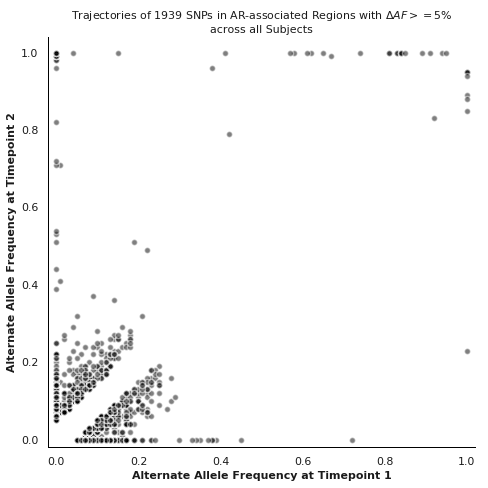

In [25]:
fig , ax = plt.subplots()
epsilon = 0.02

plt.scatter( alt_AF_1_array , alt_AF_2_array  , color = '0.0' , edgecolor = 'white' , linewidth = 1.5 , alpha = 0.5 , s = 35)

#plot Line of Best Fit from OLS regression
#plt.plot(X_values_line_best_fit , Y_values_line_best_fit , color = 'xkcd:bright red' , linestyle = '-' , linewidth = 1.5 , zorder=0 , alpha = 1.0)
#plt.plot(X_values_line_best_fit , X_values_line_best_fit , color = 'k' , linestyle = '--' , linewidth = 1.0 , zorder=0 , alpha = 1.0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

plt.ylabel('Alternate Allele Frequency at Timepoint 2' , fontweight = 'bold', fontsize = 11 , color = 'k')
plt.xlabel('Alternate Allele Frequency at Timepoint 1' , fontweight = 'bold', fontsize = 11 , color = 'k')

plt.title( 'Trajectories of 1939 SNPs in AR-associated Regions with $\Delta AF >= 5 \%$\nacross all Subjects' , fontsize = 11 , color = 'k')

plt.xlim(0.0-epsilon , np.max(alt_AF_1_array)+epsilon)
plt.ylim(0.0-epsilon , np.max(alt_AF_2_array)+epsilon+0.02)

fig = plt.gcf()
fig.set_size_inches(7.0, 7.0)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/antibiotic_resistance_analysis/alt1_vs_alt2_for_AR_SNPs_all_subjects.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### Heatmap version of plot above

In [26]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

In [26]:
#define colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval), cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def heatmap_AF1_vs_AF2(X , Y , color_map , file_name):
    #############  create AF_1 vs AF_2 scatter plot  #############
    fig = plt.figure(figsize=(7, 7.7), dpi=100)
    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1,
                           width_ratios = [1],
                           height_ratios = [50,1.5],
                           wspace=0.00,
                           hspace=0.19)



    cmap = plt.get_cmap(color_map)
    trunc_cmap = truncate_colormap(cmap, 0.07, 1.0)

    #HEATMAP
    axmatrix = fig.add_subplot(gs[0])

    # turn off the frame
    axmatrix.set_frame_on(False)


    X = X + 0.0001 #add psuedo-count to push into bin next-over (to the right)
    Y = Y + 0.0001 #add psuedo-count to push into bin next-over (to the right)

    heatmap_array , xedges , yedges = np.histogram2d(X , Y , bins = 101)
    norm = mpl.colors.PowerNorm(gamma=1./5.3)
    heatmap = plt.pcolor(heatmap_array.T , cmap = trunc_cmap , norm = norm , edgecolors = '1.0', linewidth = 0.35)

    #X-TICKS
    #------------------------------------------------------------------------------------------------------------------------
    axmatrix.set_xticks(np.arange(0 , 101 , 10) + 0.5, minor=False)
    axmatrix.set_xticklabels( [str(float(decimal.Decimal(str(tick_i)))) for tick_i in np.arange(0.0 , 1.01 , 0.10) ] , rotation='horizontal', fontsize = 7)
    axmatrix.tick_params(labelsize=8 , pad = 1.5 , axis = 'x')

    #Y-TICKS
    #------------------------------------------------------------------------------------------------------------------------
    axmatrix.set_yticks(np.arange(0 , 101 , 10) + 0.5, minor=False)
    axmatrix.set_yticklabels( [str(float(decimal.Decimal(str(tick_i)))) for tick_i in np.arange(0.0 , 1.01 , 0.10) ] , rotation='horizontal', fontsize = 7)
    axmatrix.tick_params(labelsize=8 , pad = 1.5 , axis = 'y')

    #COLORBAR
    #------------------------------------------------------------------------------------------------------------------------
    color_bar_ax = fig.add_subplot(gs[1])
    cb = plt.colorbar( heatmap , cax = color_bar_ax , orientation = 'horizontal' , ticks = [0] + list( np.ceil( np.logspace( math.log(1 , 5) , math.log(int(np.max( heatmap_array )) , 5)  , num = 9 , base = 5)).astype(int) ) + [int(np.max( heatmap_array ))] ) 
    cb.outline.set_linewidth(0.0)
    color_bar_ax.tick_params(labelsize=7 , pad = 3)
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
    #------------------------------------------------------------------------------------------------------------------------

    axmatrix.set_ylabel('Alternate Allele Frequency at Timepoint 2' , color = 'k' , fontsize = 10)
    axmatrix.set_xlabel('Alternate Allele Frequency at Timepoint 1' , color = 'k' , fontsize = 10)
    axmatrix.set_title( 'Trajectories of 1939 SNPs in AR-associated Regions with $\Delta AF >= 5 \%$\nacross all Subjects' , fontsize = 10 , color = 'k')

    axmatrix.tick_params(labelcolor = 'k')
    
    #output for Adobe Illustrator
    plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)
    
    plt.show()

    ##################################################################

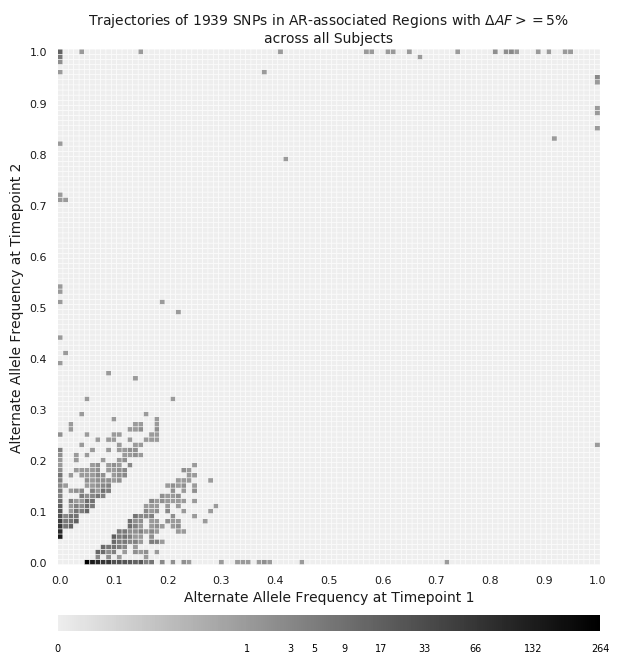

In [27]:
#color within-host Base Calls w/ a difference in Alternate Allele Frequencies >= 1% in Green (SNPs that we ARE taking into account)
X = alt_AF_1_array
Y = alt_AF_2_array
color_map = 'gist_gray_r'
file_name = file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/antibiotic_resistance_analysis/alt1_vs_alt2_for_AR_SNPs_failure_relapse_subjects_heatmap.pdf'
heatmap_AF1_vs_AF2(X , Y , color_map , file_name)

In [27]:
len(alt_AF_1_array)

1939

In [28]:
len(alt_AF_2_array)

1939

#### Calculate TPR & FPR (using an AR fixation threshold of 75%)

In [29]:
AF_fixation_threshold = 0.75

###########
#DISCARD SNPs if AF1 >= AF_fixation_threshold and AF2 >= AF_fixation_threshold
###########
SNPs_fixed_both_timepoints = [ (AF1 >= AF_fixation_threshold) and (AF2 >= AF_fixation_threshold) for AF1 , AF2 in zip( alt_AF_1_array , alt_AF_2_array ) ]
SNPs_not_fixed_both_timespoints = np.array( [not fixed_both_timepoints for fixed_both_timepoints in SNPs_fixed_both_timepoints] )

alt_AF_1_array = alt_AF_1_array[SNPs_not_fixed_both_timespoints]

alt_AF_2_array = alt_AF_2_array[SNPs_not_fixed_both_timespoints]
###########

In [30]:
len(alt_AF_1_array)

1919

In [31]:
len(alt_AF_2_array)

1919

#### How many of the 1,919 nSNPs had 

1. $AF_1 = 0\%$ and $AF_2 > 75\%$

2. $AF_1 \ge 1\%$ and $AF_2 > 75\%$

these would be the SNPs undetectable in the first timepoint that swept and fixed

In [32]:
np.sum((alt_AF_1_array == 0) & (alt_AF_2_array > 0.75))

25

In [33]:
np.sum((alt_AF_1_array >= 0.01) & (alt_AF_2_array > 0.75))

12

In [34]:
#take arrays for AF1 , AF2 and join into 1 array
alt_AF_array = np.vstack((alt_AF_1_array , alt_AF_2_array))
alt_AF_array = alt_AF_array.T

#rates of True Positives for every alt_AF1 classfier
TP_dict = {}

#rates of False Positives for every alt_AF1 classfier
FP_dict = {}

num_SNPs = float(len(alt_AF_1_array))

for alt_AF in np.arange(0.0 , 1.01 , 0.01):
    
    #boolean for SNPs with alt AF1 >= alt_AF varying classifier
    SNPs_classified_as_fixed_bool = alt_AF_array[: , 0] >= alt_AF

    #boolean for SNPs with alt AF2 >= fixation threshold
    SNPs_actually_fixed_bool = alt_AF_array[: , 1] >= AF_fixation_threshold

    #True Positives: SNPs classified as going to fix (alt AF1 >= varying freq) and actually fixed ( alt AF2 >= fixation threshold )
    TP_bool = [(classified_fixed) and (fixed) for classified_fixed , fixed in zip(SNPs_classified_as_fixed_bool , SNPs_actually_fixed_bool)]

    #False Positives: SNPs classfifed as going to fix (alt AF1 >= varying freq) and NOT fixed (alt AF2 < fixation threshold)
    FP_bool = [(classified_fixed) and (not fixed) for classified_fixed , fixed in zip(SNPs_classified_as_fixed_bool , SNPs_actually_fixed_bool)]
    
    #True Negatives: SNPs not classified as going to fix (alt AF1 < varying freq) and NOT fixed (alt AF2 < fixation threshold)
    TN_bool = [(not classified_fixed) and (not fixed) for classified_fixed , fixed in zip(SNPs_classified_as_fixed_bool , SNPs_actually_fixed_bool)]
    
    #False Negatives : SNPs not classified as going to fix (alt AF1 < varying freq) and actually fixed ( alt AF2 >= fixation threshold )
    FN_bool = [(not classified_fixed) and (fixed) for classified_fixed , fixed in zip(SNPs_classified_as_fixed_bool , SNPs_actually_fixed_bool)]

    #calculate True & False positive rates
    TP_rate = float(sum(TP_bool)) / float(sum(TP_bool) + sum(FN_bool))
    FP_rate = float(sum(FP_bool)) / float(sum(FP_bool) + sum(TN_bool))
    
    TP_dict[alt_AF] = TP_rate
    FP_dict[alt_AF] = FP_rate

#convert dicts -> series
TP_rates = pd.Series(TP_dict)
FP_rates = pd.Series(FP_dict)

In [35]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

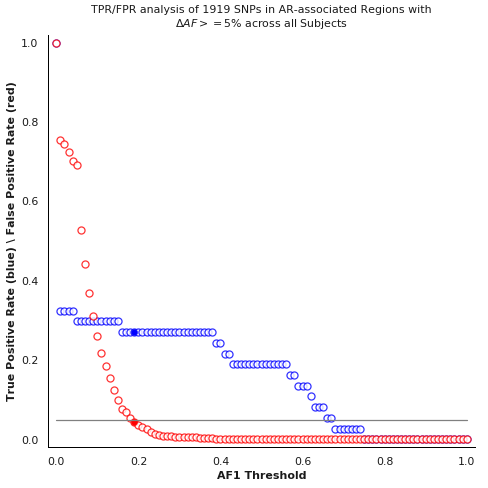

In [36]:
fig , ax = plt.subplots()
epsilon = 0.02

#use this to change size of points as AF1 classifier increases
AF1_classifying_thresholds = np.arange(0.0 , 1.01 , 0.01)

plt.scatter( AF1_classifying_thresholds , TP_rates , color = '1.0' , marker = 'o' , edgecolor = 'blue' , linewidth = 1.25 , alpha = 0.80 , s = 50)
plt.scatter( AF1_classifying_thresholds , FP_rates , color = '1.0' , marker = 'o' , edgecolor = 'red' , linewidth = 1.25 , alpha = 0.80 , s = 50)
plt.scatter( 0.19 , TP_rates[0.19] , color = 'blue' , marker = 'o')
plt.scatter( 0.19 , FP_rates[0.19] , color = 'red' , marker = 'o')

plt.plot([0.0 , 1.0] , [0.05 , 0.05] , c = '0.5', linestyle = '-' , linewidth = 1.25)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

plt.ylabel('True Positive Rate (blue) \ False Positive Rate (red)' , fontweight = 'bold', fontsize = 11 , color = 'k')
plt.xlabel('AF1 Threshold' , fontweight = 'bold', fontsize = 11 , color = 'k')

plt.title( 'TPR/FPR analysis of 1919 SNPs in AR-associated Regions with\n$\Delta AF >= 5 \%$ across all Subjects', fontsize = 11 , color = 'k')

plt.xlim(0.0 - epsilon , 1.0 + epsilon)
plt.ylim(0.0 - epsilon , 1.0 + epsilon)

fig = plt.gcf()
fig.set_size_inches(7.0, 7.0)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/antibiotic_resistance_analysis/TPR_FPR_vs_AF1_threshold_for_AR_SNPs_all_subjects_fixation_thresh_75.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [37]:
FP_rates[FP_rates <= 0.05].head()

0.19    0.042508
0.20    0.037194
0.21    0.032412
0.22    0.025505
0.23    0.019660
dtype: float64

Sensitivity

In [38]:
TP_rates[0.19]

0.2702702702702703

Specificity

In [39]:
1 - FP_rates[0.19]

0.9574920297555791

In [40]:
TP = sum( [ (AF1 >= 0.19) and (AF2 >= AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] )
print TP

10


In [41]:
FP = sum( [ (AF1 >= 0.19) and (AF2 < AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] )
print FP

80


In [42]:
TN = sum( [ (AF1 < 0.19) and (AF2 < AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] )
print TN

1802


In [43]:
FN = sum( [ (AF1 < 0.19) and (AF2 >= AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] )
print FN

27


In [44]:
Sensitivity = float(TP) / (float(TP) + float(FN))
print Sensitivity

0.27027027027


In [45]:
Specificity = 1 - (float(FP) / (float(FP) + float(TN)))
print Specificity

0.957492029756


Get the number of isolates that had $19\% \le \text{AF}_1 <75\%$ and $\text{AF}_2 \ge 75\%$

In [46]:
bool_filter = np.array( [ (AF1 >= 0.19) and (AF2 >= AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] )

In [47]:
alt_AF_array[: , 0][bool_filter]

array([0.62, 0.67, 0.65, 0.74, 0.42, 0.61, 0.38, 0.41, 0.58, 0.57])

In [48]:
alt_AF_array[: , 1][bool_filter]

array([1.  , 0.99, 1.  , 1.  , 0.79, 1.  , 0.96, 1.  , 1.  , 1.  ])

In [49]:
print np.mean( alt_AF_array[: , 1][bool_filter] - alt_AF_array[: , 0][bool_filter] )

0.409


#### Breakdown of SNPs that fixed

$\text{AF}_1 \ge 19\%$ and $\text{AF}_2 \ge 75\%$

In [56]:
sum( [ (AF1 >= 0.19) and (AF2 >= AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] ) #TP

10

$0\% < \text{AF}_1 < 19\%$ and $\text{AF}_2 \ge 75\%$

In [57]:
sum( [ (0 < AF1 < 0.19) and (AF2 >= AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] ) #FN

2

$\text{AF}_1 = 0\%$ and $\text{AF}_2 \ge 75\%$

In [58]:
sum( [ (AF1 == 0) and (AF2 >= AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] ) #FN

25

#### Breakdown of SNPs that didn't fix

$\text{AF}_1 \ge 19\%$ and $\text{AF}_2 < 75\%$

In [59]:
sum( [ (AF1 >= 0.19) and (AF2 < AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] )

80

$0\% < \text{AF}_1 < 19\%$ and $\text{AF}_2 < 75\%$

In [60]:
sum( [ (0 < AF1 < 0.19) and (AF2 < AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] )

1342

$\text{AF}_1 = 0\%$ and $\text{AF}_2 < 75\%$

In [61]:
sum( [ (AF1 == 0) and (AF2 < AF_fixation_threshold) for AF1 , AF2 in zip( list(alt_AF_array[: , 0]) , list(alt_AF_array[: , 1]) ) ] )

460

#### In how many isolate/subjects did the above SNPs appear within?

In [50]:
np.shape(within_host_Base_Call_variants_all_patients_sample_order)

(3878, 19)

In [51]:
within_host_Base_Call_variants_all_patients_sample_order.head(n=2)

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order
0,T,G,2726338,867,Ref_PASS,[],"{u'QP': [0, 0, 12, 87], u'AC': [0], u'AF': [0....",0.12,62,ERR108174,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,2
1,T,G,2726338,182,Ref_PASS,[],"{u'QP': [0, 0, 22, 77], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,1


In [52]:
Base_Call_indices_to_keep = []

#for each pair of Base Calls, store (alternate Allele Frequency of isolate_1) and (alternate Allele Frequency of isolate_2 - alternate Allele Frequency of isolate_1)
for Base_Call_A_index , Base_Call_B_index in zip( range(0 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) , range(1 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) ):
    
    #pull alternate AFs
    if within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'sample_order'] == 1:
        
        alt_AF_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'alt_AF']
        alt_AF_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , 'alt_AF']
        
        if not( (alt_AF_1 >= AF_fixation_threshold) and (alt_AF_2 >= AF_fixation_threshold) ):
        
            if (alt_AF_1 >= 0.19) and (alt_AF_2 >= AF_fixation_threshold):
                Base_Call_indices_to_keep.append(Base_Call_A_index)
                Base_Call_indices_to_keep.append(Base_Call_B_index)
        
    elif within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'sample_order'] == 2:
        
        alt_AF_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'alt_AF']
        alt_AF_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , 'alt_AF']
        
        if not( (alt_AF_1 >= AF_fixation_threshold) and (alt_AF_2 >= AF_fixation_threshold) ):
        
            if (alt_AF_1 >= 0.19) and (alt_AF_2 >= AF_fixation_threshold):
                Base_Call_indices_to_keep.append(Base_Call_A_index)
                Base_Call_indices_to_keep.append(Base_Call_B_index)

In [53]:
print(float(len(Base_Call_indices_to_keep)) / 2) #number of mutations that fit criteria

10.0


In [54]:
within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_indices_to_keep , :]

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order
10,G,T,2289042,4905,Amb,[Amb],"{u'QP': [0, 0, 38, 62], u'AC': [1], u'AF': [0....",0.62,249,Peru5139,CETR,2968,Rv2043c,200,Antibiotic Resistance,pncA,N,S67*,1
11,G,T,2289042,14023,Alt_PASS,[],"{u'QP': [0, 0, 0, 99], u'AC': [2], u'AF': [1.0...",1.00,371,Peru5140,CETR,2968,Rv2043c,200,Antibiotic Resistance,pncA,N,S67*,2
20,A,C,4407967,2309,Amb,[Amb],"{u'QP': [33, 67, 0, 0], u'AC': [1], u'AF': [0....",0.67,194,Peru5139,CETR,2968,Rv3919c,236,Antibiotic Resistance,gid,N,L79W,1
21,A,C,4407967,14346,Alt_PASS,[],"{u'QP': [1, 99, 0, 0], u'AC': [2], u'AF': [0.9...",0.99,379,Peru5140,CETR,2968,Rv3919c,236,Antibiotic Resistance,gid,N,L79W,2
1030,A,C,7582,16742,Alt_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [2], u'AF': [1....",1.00,426,Peru5132,CETR,2556,Rv0006,281,Antibiotic Resistance,gyrA,N,D94A,2
1031,A,C,7582,1391,Amb,[Amb],"{u'QP': [35, 65, 0, 0], u'AC': [1], u'AF': [0....",0.65,93,Peru4722,CETR,2556,Rv0006,281,Antibiotic Resistance,gyrA,N,D94A,1
1040,A,C,4326771,103,Amb,[Amb],"{u'QP': [26, 74, 0, 0], u'AC': [1], u'AF': [0....",0.74,102,Peru4722,CETR,2556,Rv3854c,703,Antibiotic Resistance,ethA,N,Y235D,1
1041,A,C,4326771,17723,Alt_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [2], u'AF': [1....",1.00,460,Peru5132,CETR,2556,Rv3854c,703,Antibiotic Resistance,ethA,N,Y235D,2
1048,A,G,7582,756,Amb,[Amb],"{u'QP': [58, 0, 42, 0], u'AC': [1], u'AF': [0....",0.42,31,Peru4690,CETR,2319,Rv0006,281,Antibiotic Resistance,gyrA,N,D94G,1
1049,A,G,7582,861,Alt_PASS,[],"{u'QP': [21, 0, 79, 0], u'AC': [2], u'AF': [0....",0.79,128,Peru5120,CETR,2319,Rv0006,281,Antibiotic Resistance,gyrA,N,D94G,2


#################################################################################################################################################################################################################################

## [4] Analysis 2 - Logistic Regression

#################################################################################################################################################################################################################################

#### Subset to 'fixed' AR SNPs with $\Delta AF >= 40\%$

In [55]:
all_SNPs_within_patients_AR_fSNPs = all_SNPs_within_patients[all_SNPs_within_patients.alt_AF_difference >= 0.40]

In [56]:
np.shape(all_SNPs_within_patients_AR_fSNPs)

(41, 12)

In [57]:
all_SNPs_within_patients_AR_fSNPs.head()

,population,patient_id,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,alt_AF_difference,SNP_type,AA_change
3,CASALI,P251,761139,1333,C,G,Rv0667,Antibiotic Resistance,rpoB,1.00,N,H445D
7,CETR,2968,4269313,521,T,G,Rv3806c,Antibiotic Resistance,NaN,0.45,N,K174T
155,CETR,I0000024-5,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,0.99,N,E501D
359,GUERRA,KPS_37,2154154,1958,A,T,Rv1908c,Antibiotic Resistance,katG,1.00,N,L653Q
374,CETR,1700,2154973,1139,G,A,Rv1908c,Antibiotic Resistance,katG,0.51,N,T380I


#### Get timing between isolate collection for each subject

In [58]:
time_between_serial_isolate_collection = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_sample_annotation_for_temporal_analysis_with_dates.csv').set_index('population')

In [59]:
time_between_serial_isolate_collection.head()

,Unnamed: 0,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,,
BRYANT,0,ERR108130,400044,1,ERR108130,longitudinal,2020E,0,NaN,NaN
BRYANT,1,ERR108129,401206,2,ERR108129,longitudinal,2020E,36,NaN,NaN
BRYANT,2,ERR108131,400673,1,ERR108131,longitudinal,2027W,0,NaN,NaN
BRYANT,3,ERR108132,402568,2,ERR108132,longitudinal,2027W,48,NaN,NaN
BRYANT,4,ERR108133,400711,1,ERR108133,longitudinal,2028K,0,NaN,NaN


In [60]:
np.shape(time_between_serial_isolate_collection)

(400, 10)

#### Retain only patients that for which we have date Information for both samples

In [61]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 7] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 7] )

#get a boolean to check that there are dates for both samples
dates_for_both_samples = [ ( (isinstance(date_1, basestring)) and (isinstance(date_2, basestring)) ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [62]:
np.shape(time_between_serial_isolate_collection)

(396, 10)

In [63]:
np.shape(time_between_serial_isolate_collection_dropped )

(4, 10)

#### Dropped 2 patients from Witney et. al. dataset that didn't have date information both both isolates - WITNEY:27 & WITNEY:28

In [64]:
time_between_serial_isolate_collection_dropped 

,Unnamed: 0,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,,
WITNEY,380,ERR1750925,SAMEA23779168,1,ERR1750925,longitudinal,27,NaN,NaN,NaN
WITNEY,381,ERR1750926,SAMEA23779918,2,ERR1750926,longitudinal,27,1/25/11,NaN,NaN
WITNEY,382,ERR1750927,SAMEA23780668,1,ERR1750927,longitudinal,28,NaN,NaN,NaN
WITNEY,383,ERR1750928,SAMEA23781418,2,ERR1750928,longitudinal,28,8/3/11,NaN,NaN


#### Drop samples that have the same date as collection date for both isolates

In [65]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 7] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 7] )

#check to make sure that the dates of collection differ between both samples
dates_differ_for_both_samples = [date_1 != date_2 for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_differ_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [66]:
np.shape(time_between_serial_isolate_collection)

(390, 10)

In [67]:
np.shape(time_between_serial_isolate_collection_dropped )

(6, 10)

#### Dropped 3 patients from Walker et. al. dataset that had same date information both both isolates - WALKER:P000059, WALKER:P000259 & WALKER:P000267

In [68]:
time_between_serial_isolate_collection_dropped 

,Unnamed: 0,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,,
WALKER,310,ERR046918,NaN,1,ERR046918,longitudinal,P000059,2007,NaN,NaN
WALKER,311,ERR046933,NaN,2,ERR046933,longitudinal,P000059,2007,NaN,NaN
WALKER,342,ERR047010,NaN,1,ERR047010,longitudinal,P000259,2008,NaN,NaN
WALKER,343,ERR047012,NaN,2,ERR047012,longitudinal,P000259,2008,NaN,NaN
WALKER,346,ERR047007,NaN,1,ERR047007,longitudinal,P000267,2007,NaN,NaN
WALKER,347,ERR072030,NaN,2,ERR072030,longitudinal,P000267,2007,NaN,NaN


In [69]:
num_patients = np.shape(time_between_serial_isolate_collection)[0] / 2
print num_patients

195


#### Get Pairwise distances for AR fSNPs for all subjects

In [70]:
pairwise_variant_distances = pd.DataFrame(index = patients_to_keep , columns = ['population' , 'pairwise_AR_fSNP_distance' , 'time_between_collection'])

for patient_id in patients_to_keep:
    
    population = sample_annotation.loc[patient_id , 'population'].values[0]
    
    #pairwise distance between isolates
    SNP_distance = np.sum(all_SNPs_within_patients_AR_fSNPs.patient_id == patient_id)
    
    #append info to dataframe
    pairwise_variant_distances.loc[patient_id , 'population'] = population
    pairwise_variant_distances.loc[patient_id , 'pairwise_AR_fSNP_distance'] = SNP_distance

In [71]:
pairwise_variant_distances.head()

,population,pairwise_AR_fSNP_distance,time_between_collection
2020E,BRYANT,0,NaN
2027W,BRYANT,0,NaN
2028K,BRYANT,0,NaN
2041Q,BRYANT,0,NaN
2043R,BRYANT,0,NaN


In [72]:
np.shape(pairwise_variant_distances)

(195, 3)

#### Find distance between all pairs of times

In [73]:
for patient_id in pairwise_variant_distances.index:
    
    population = pairwise_variant_distances.loc[patient_id , 'population']
    patient_id = patient_id
    
    if population == 'BRYANT':
        
        bryant_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]
        
        first_date = bryant_pair[bryant_pair.sample_order == 1].date_information.values[0]
        second_date = bryant_pair[bryant_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
    
    if population == 'CASALI':
        
        casali_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = casali_pair[casali_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[0]
        month = first_date.split('/')[1]
        year = '20' + first_date.split('/')[2]
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = casali_pair[casali_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[0]
        month = second_date.split('/')[1]
        year = '20' + second_date.split('/')[2]
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'CETR') or (population == 'GUERRA') or (population == 'WITNEY') or (population == 'XU'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[1]
        month = first_date.split('/')[0]
        if int(first_date.split('/')[2]) in range(50,100): #some dates in 1990's others in 2000's
            year = '19' + first_date.split('/')[2]
        else:
            year = '20' + first_date.split('/')[2]

        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))


        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[1]
        month = second_date.split('/')[0]
        if int(second_date.split('/')[2]) in range(50,100):
            year = '19' + second_date.split('/')[2]
        else:
            year = '20' + second_date.split('/')[2]

        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'TRAUNER') or (population == 'BRYANT'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
        
    elif population == 'WALKER':
        
        walker_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = walker_pair[walker_pair.sample_order == 1].date_information.values[0]
        day = '1'
        month = '1'
        year = first_date
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = walker_pair[walker_pair.sample_order == 2].date_information.values[0]
        day = '1'
        month = '1'
        year = second_date
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    #append distance between isolate collection
    pairwise_variant_distances.loc[patient_id , 'time_between_collection'] = num_days_between

In [74]:
pairwise_variant_distances.head()

,population,pairwise_AR_fSNP_distance,time_between_collection
2020E,BRYANT,0,252
2027W,BRYANT,0,336
2028K,BRYANT,0,182
2041Q,BRYANT,0,182
2043R,BRYANT,0,252


In [75]:
np.shape(pairwise_variant_distances) #195 subjects with date information for both isolates

(195, 3)

In [76]:
pairwise_variant_distances.pairwise_AR_fSNP_distance.sum()

38

#### convert time between isolate collection to months (30 days)

In [77]:
pairwise_variant_distances.loc[: , 'time_between_collection'] = pairwise_variant_distances.time_between_collection.astype(float) / 30.0
pairwise_variant_distances.loc[: , 'time_between_collection'] = [round(x, 2) for x in pairwise_variant_distances.time_between_collection] #round the nearest 2nd decimal place

In [78]:
pairwise_variant_distances.head()

,population,pairwise_AR_fSNP_distance,time_between_collection
2020E,BRYANT,0,8.40
2027W,BRYANT,0,11.20
2028K,BRYANT,0,6.07
2041Q,BRYANT,0,6.07
2043R,BRYANT,0,8.40


### Logistic Regression

Define *Independent* and *Dependent* variables

In [79]:
x = np.array(pairwise_variant_distances.time_between_collection).reshape(-1, 1)
x = x.astype(float)
x = sm.add_constant(x)

y = np.array([int(i) for i in list(pairwise_variant_distances.pairwise_AR_fSNP_distance > 0)])
y = y.astype(float)

Create a Model and Train It

In [80]:
model = sm.Logit(y, x)

result = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.391535
         Iterations 6


In [81]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:                          Logit   Df Residuals:                      193
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                 0.02642
Time:                        15:21:08   Log-Likelihood:                -76.349
converged:                       True   LL-Null:                       -78.421
Covariance Type:            nonrobust   LLR p-value:                   0.04178
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1965      0.286     -7.680      0.000      -2.757      -1.636
x1             0.0226      0.011      2.108      0.035       0.002       0.044
==============================================================================
"""

In [82]:
result.params

array([-2.19650369,  0.02263397])

In [83]:
result.pvalues

array([1.58676915e-14, 3.50415023e-02])

In [84]:
result.conf_int()

array([[-2.75703521e+00, -1.63597217e+00],
       [ 1.58827542e-03,  4.36796560e-02]])

In [85]:
coeff_x = result.params[1]
coeff_x_95_CF = result.conf_int()[1,:]

Calculate Odds Ratio

In [86]:
OR_x = np.exp(coeff_x)
print OR_x

1.0228920574737548


In [87]:
OR_x_95_CF = np.exp(coeff_x_95_CF)
print OR_x_95_CF

[1.00158954 1.04464765]


Odds Ratio OR (95% CI) = 1.0229 (1.0016 , 1.0446)

p-val = 0.035

#################################################################################################################################################################################################################################

## [5] Analysis 3 - Clonal Interference Patterns

#################################################################################################################################################################################################################################

In [88]:
within_host_Base_Call_variants_all_patients_sample_order.head()

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order
0,T,G,2726338,867,Ref_PASS,[],"{u'QP': [0, 0, 12, 87], u'AC': [0], u'AF': [0....",0.12,62,ERR108174,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,2
1,T,G,2726338,182,Ref_PASS,[],"{u'QP': [0, 0, 22, 77], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,1
2,T,G,2726341,234,Ref_PASS,[],"{u'QP': [0, 0, 22, 78], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G,1
3,T,G,2726341,931,Ref_PASS,[],"{u'QP': [0, 0, 11, 89], u'AC': [0], u'AF': [0....",0.11,59,ERR108174,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G,2
4,A,C,4049577,772,Ref_PASS,[],"{u'QP': [88, 12, 0, 0], u'AC': [0], u'AF': [0....",0.12,52,ERR108173,BRYANT,4024R,Rv3608c,404,Antibiotic Resistance,folP1,N,V135G,1


In [89]:
np.shape(within_host_Base_Call_variants_all_patients_sample_order)

(3878, 19)

In [90]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

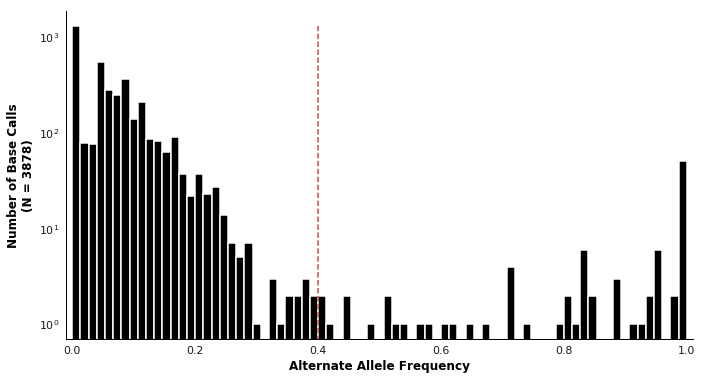

In [91]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(list(within_host_Base_Call_variants_all_patients_sample_order.alt_AF) , rwidth = 1.0 , edgecolor='white', bins = 75 , linewidth = 1.5 , color = 'black')
plt.plot([.4 , .4] , [0 , max(n)] , 'r--' , linewidth = 1.5)

plt.xlabel('Alternate Allele Frequency', fontweight = 'bold' , fontsize = 12, color = 'black')
plt.ylabel('Number of Base Calls\n(N = ' + str(np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0]) + ')', fontweight = 'bold' , fontsize = 12, color = 'black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_yscale("log", nonposy='clip')
ax.tick_params(direction='out', length=3, width=1.25, colors='k') #make tick marks darker

ax.set_xlim(-0.01 , 1.01)

fig = plt.gcf()
fig.set_size_inches(10.0, 5.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/antibiotic_resistance_analysis/clonal_interference_examples/alt_AF_distribution_all_AR_SNPs.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [92]:
within_host_Base_Call_variants_all_patients_sample_order.head()

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order
0,T,G,2726338,867,Ref_PASS,[],"{u'QP': [0, 0, 12, 87], u'AC': [0], u'AF': [0....",0.12,62,ERR108174,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,2
1,T,G,2726338,182,Ref_PASS,[],"{u'QP': [0, 0, 22, 77], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,146,Antibiotic Resistance,ahpC,N,V49G,1
2,T,G,2726341,234,Ref_PASS,[],"{u'QP': [0, 0, 22, 78], u'AC': [0], u'AF': [0....",0.22,73,ERR108173,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G,1
3,T,G,2726341,931,Ref_PASS,[],"{u'QP': [0, 0, 11, 89], u'AC': [0], u'AF': [0....",0.11,59,ERR108174,BRYANT,4024R,Rv2428,149,Antibiotic Resistance,ahpC,N,V50G,2
4,A,C,4049577,772,Ref_PASS,[],"{u'QP': [88, 12, 0, 0], u'AC': [0], u'AF': [0....",0.12,52,ERR108173,BRYANT,4024R,Rv3608c,404,Antibiotic Resistance,folP1,N,V135G,1


#### List of subjects that have at least 1 SNP within-host

In [94]:
subject_ids = list( set( list( within_host_Base_Call_variants_all_patients_sample_order.patient_id ) ) )

In [95]:
clonal_interference_SNP_candidates = pd.DataFrame(columns = within_host_Base_Call_variants_all_patients_sample_order.columns)

for subject_id in subject_ids:
    
    within_host_Base_Call_variants_for_patient = within_host_Base_Call_variants_all_patients_sample_order[within_host_Base_Call_variants_all_patients_sample_order.patient_id == subject_id]

    for gene_id in list(set(list(within_host_Base_Call_variants_for_patient.gene_id))):

        within_host_Base_Call_variants_for_patient_and_geneID = within_host_Base_Call_variants_for_patient[within_host_Base_Call_variants_for_patient.gene_id == gene_id]

        #1st AFs
        sample_1_AFs = []
        #2nd AFs
        sample_2_AFs = []

        #for each pair of Base Calls, store (alternate Allele Frequency of isolate_1) and (alternate Allele Frequency of isolate_2 - alternate Allele Frequency of isolate_1)
        for Base_Call_A_index , Base_Call_B_index in zip( list( within_host_Base_Call_variants_for_patient_and_geneID.iloc[ range(0 , np.shape(within_host_Base_Call_variants_for_patient_and_geneID)[0] , 2) ].index ) , list( within_host_Base_Call_variants_for_patient_and_geneID.iloc[ range(1 , np.shape(within_host_Base_Call_variants_for_patient_and_geneID)[0] , 2) ].index ) ):

            #pull alternate AF & sample number for each isolate in pair
            if  within_host_Base_Call_variants_for_patient_and_geneID.loc[Base_Call_A_index , 'sample_order'] == 1:

                Base_Call_H37Rv_AF_1 = within_host_Base_Call_variants_for_patient_and_geneID.loc[Base_Call_A_index , 'alt_AF']
                Base_Call_H37Rv_AF_2 = within_host_Base_Call_variants_for_patient_and_geneID.loc[Base_Call_B_index , 'alt_AF']

            elif within_host_Base_Call_variants_for_patient_and_geneID.loc[Base_Call_A_index , 'sample_order'] == 2:

                Base_Call_H37Rv_AF_2 = within_host_Base_Call_variants_for_patient_and_geneID.loc[Base_Call_A_index , 'alt_AF']
                Base_Call_H37Rv_AF_1 = within_host_Base_Call_variants_for_patient_and_geneID.loc[Base_Call_B_index , 'alt_AF']

            #store 1st & 2nd AFs in lists
            sample_1_AFs.append(Base_Call_H37Rv_AF_1)
            sample_2_AFs.append(Base_Call_H37Rv_AF_2)

        #see if any AFs > 0.40
        if sum(np.array(sample_1_AFs + sample_2_AFs) >= 0.40 ) > 0:
            
            #check to see if AFs for any SNPs within the same subject & gene 'move in' opposite directions
            if ( sum( np.array( sample_1_AFs ) < np.array(sample_2_AFs) ) == len(sample_1_AFs) ) or ( sum( np.array( sample_1_AFs ) > np.array(sample_2_AFs) ) == len(sample_1_AFs) ):
                pass
            else:
                clonal_interference_SNP_candidates = clonal_interference_SNP_candidates.append(within_host_Base_Call_variants_for_patient_and_geneID)
                
#reset index
clonal_interference_SNP_candidates.reset_index(inplace = True , drop = True)

#### Check for evidence of clonal interference in Intergenic regions

In [96]:
clonal_interference_SNP_candidates[clonal_interference_SNP_candidates.SNP_ftype == 'I']

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order


No intergenic regions have SNPs that fit the criteria for clonal interference pattern

In [97]:
clonal_interference_SNP_candidates.head()

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order
0,T,G,4247510,5791,Ref_PASS,[],"{u'QP': [0, 0, 9, 91], u'AC': [0], u'AF': [0.0...",0.09,327,ERR037522,GUERRA,KPS_5,Rv3795,997,Antibiotic Resistance,embB,N,Y333D,1
1,T,Z,4247510,1772,Ref_PASS,[],"{u'QP': [0, 0, 0, 100], u'AC': [0], u'AF': [0....",0.00,59,ERR212078,GUERRA,KPS_5,Rv3795,997,Antibiotic Resistance,embB,None,None,2
2,C,Z,4247603,1998,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'AF': [0....",0.00,57,ERR212078,GUERRA,KPS_5,Rv3795,1090,Antibiotic Resistance,embB,None,None,2
3,C,G,4247603,4504,Ref_PASS,[],"{u'QP': [0, 94, 6, 0], u'AC': [0], u'AF': [0.0...",0.06,223,ERR037522,GUERRA,KPS_5,Rv3795,1090,Antibiotic Resistance,embB,N,L364V,1
4,T,G,4247619,3464,Ref_PASS,[],"{u'QP': [0, 0, 6, 94], u'AC': [0], u'AF': [0.0...",0.06,219,ERR037522,GUERRA,KPS_5,Rv3795,1106,Antibiotic Resistance,embB,N,V369G,1


In [98]:
np.shape(clonal_interference_SNP_candidates)

(70, 19)

Find all gene - subject pairs that show evidence of clonal interference

In [99]:
gene_subject_combos = list( set( [gene_id + ':' + subject_id for gene_id,subject_id in zip( list(clonal_interference_SNP_candidates.gene_id) , list(clonal_interference_SNP_candidates.patient_id) ) ] ) )

2556 : gyrA
D94A    1.0
A74S    0.0
dtype: float64
-----------------------


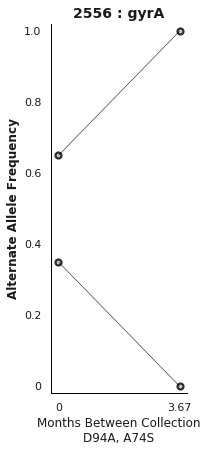

P000227 : embB
M306I    1.00
S738A    0.09
dtype: float64
-----------------------


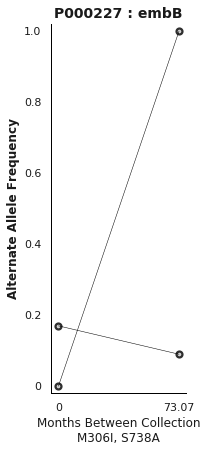

P000227 : rpoB
I491F    0.99
L815V    0.03
dtype: float64
-----------------------


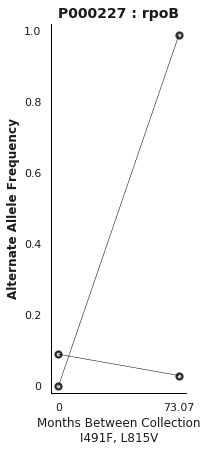

3451 : pncA
L182W    0.72
Q122*    0.23
dtype: float64
-----------------------


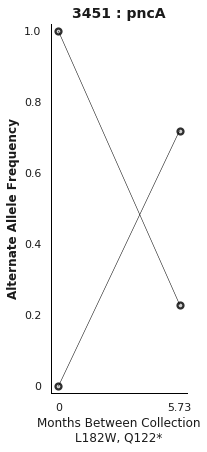

KPS_5 : embB
G406S    1.0
Y333D    0.0
V717G    0.0
V369G    0.0
L364V    0.0
dtype: float64
-----------------------


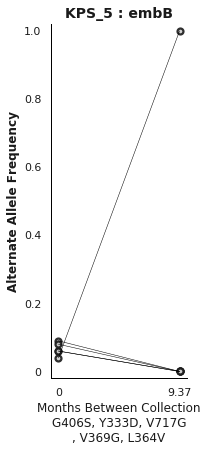

2491 : ethA
G42S    1.0
Q73*    0.0
dtype: float64
-----------------------


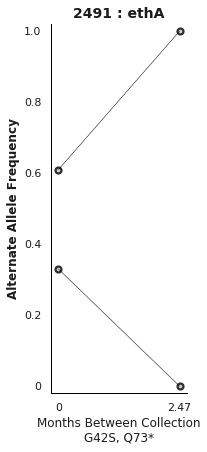

D : gyrA
D94N     1.0
A90V     1.0
Q551K    0.0
dtype: float64
-----------------------


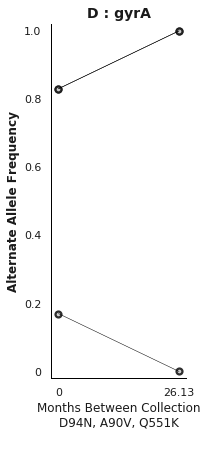

2556 : ethA
Y235D    1.0
H281R    0.0
dtype: float64
-----------------------


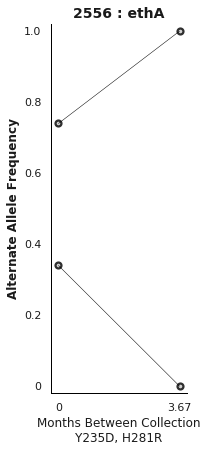

1700 : katG
S315G    0.53
T380I    0.51
Y678N    0.00
T112I    0.00
S383L    0.00
R114C    0.00
F594L    0.00
A144V    0.00
dtype: float64
-----------------------


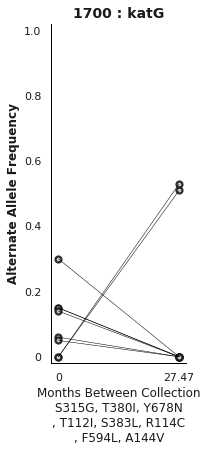

1719 : ethA
R54L     0.49
R421*    0.00
dtype: float64
-----------------------


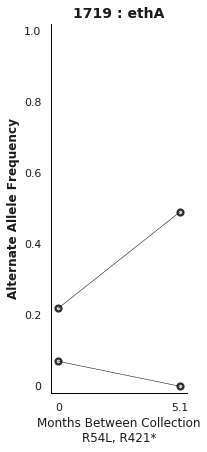

KPS_24 : katG
L159F    1.0
V151G    0.0
G99R     0.0
E452K    0.0
D440G    0.0
dtype: float64
-----------------------


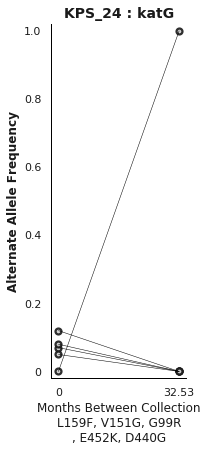

In [100]:
for gene_subject in gene_subject_combos:
    
    gene_id = gene_subject.split(':')[0]
    subject_id = gene_subject.split(':')[1]

    clonal_interference_SNP_candidates_for_gene = clonal_interference_SNP_candidates[clonal_interference_SNP_candidates.gene_id == gene_id]
    clonal_interference_SNP_candidates_for_gene_and_subject = clonal_interference_SNP_candidates_for_gene[clonal_interference_SNP_candidates_for_gene.patient_id == subject_id]
    
    #get AFs of first and second sample
    AFs_sample_1 = list( clonal_interference_SNP_candidates_for_gene_and_subject[clonal_interference_SNP_candidates_for_gene_and_subject.sample_order == 1].alt_AF )
    AFs_sample_2 = list( clonal_interference_SNP_candidates_for_gene_and_subject[clonal_interference_SNP_candidates_for_gene_and_subject.sample_order == 2].alt_AF )

    #get time between samples
    time_btwn_isolate_collection = pairwise_variant_distances.loc[subject_id , 'time_between_collection']
    gene_symbol = list(clonal_interference_SNP_candidates_for_gene_and_subject.gene_symbol)[0]
    
    #get the AA change for each SNP
    AA_change_list = []
    for sample_1_i , sample_2_i in zip(np.arange(0 , np.shape(clonal_interference_SNP_candidates_for_gene_and_subject)[0] , 2) , np.arange(1 , np.shape(clonal_interference_SNP_candidates_for_gene_and_subject)[0] , 2)):

        #get AA change
        AA_change_calls = list(clonal_interference_SNP_candidates_for_gene_and_subject.iloc[[sample_1_i , sample_2_i]].AA_change)
        try:
            AA_change_calls.remove('None')
        except ValueError:
            pass
        AA_change_list.append(AA_change_calls[0])
        
    #get a list of each AA change in decreasing order of AF at 2nd time point (SNP that swept is listed first)
    AA_change_and_AF2 = pd.Series(dict(zip(AA_change_list , AFs_sample_2))).sort_values(ascending = False)
    AA_change_ordered_by_AF2 = list(AA_change_and_AF2.index)
    
    #label for AA changes
    AA_i = 0
    AA_change_label = ''
    for AA_change in AA_change_ordered_by_AF2:

        if AA_i == 0:
            AA_change_label = AA_change
            AA_i += 1

        else:
            AA_change_label = AA_change_label + ', ' + AA_change
            AA_i += 1
            if AA_i % 3 == 0:
                AA_change_label = AA_change_label + '\n'
                
    print subject_id + ' : ' + gene_symbol
    print AA_change_and_AF2
    print '-----------------------'
    
    ####################################################################################################################################################################################

    fig , ax = plt.subplots()

    for SNP_i_AF1 , SNP_i_AF2 in zip(AFs_sample_1 , AFs_sample_2):

        plt.scatter([0 , 1] , [SNP_i_AF1 , SNP_i_AF2] , linewidth = 2.25 , edgecolor = 'k' , color = '0.8' , s = 35 , alpha = 0.90)
        plt.plot([0 , 1] , [SNP_i_AF1 , SNP_i_AF2] , linewidth = 0.5 , color = '0.0' , linestyle = '-')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xticks([0 , 1]) #xtick positions
    ax.set_xticklabels(['0' , str(time_btwn_isolate_collection)]) #xtick labels
    
    #set y limit to between 0 & 1
    ax.set_ylim(-0.02, 1.02)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) #ytick positions
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    ax.tick_params(labelcolor = 'k')

    plt.xlabel('Months Between Collection\n' + AA_change_label, fontsize = 12 , color = 'k')
    plt.ylabel('Alternate Allele Frequency' , fontweight = 'bold', fontsize = 12 , color = 'k')
    plt.title(subject_id + ' : ' + gene_symbol, fontweight = 'bold' , fontsize = 14 , color = 'k')

    fig = plt.gcf()
    fig.set_size_inches(3.0, 6.5)
    fig.tight_layout()

    file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/antibiotic_resistance_analysis/clonal_interference_examples/clonal_intererence_' + gene_subject + '.pdf'
    plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

#################################################################################################################################################################################################################################

## [6] Analysis 4 - Treatment Failure Subjects Analysis

#################################################################################################################################################################################################################################

### *Subset* to treatment failure group: $>60$ days / 2 months between isolate collection

In [93]:
pairwise_variant_distances_treatment_failure = pairwise_variant_distances[pairwise_variant_distances.time_between_collection >= 1.7]

In [94]:
np.shape(pairwise_variant_distances_treatment_failure)

(178, 3)

#### Find proportion of isolates that had an AR fSNP

In [95]:
float( np.shape(pairwise_variant_distances_treatment_failure[pairwise_variant_distances_treatment_failure.pairwise_AR_fSNP_distance > 0])[0] )

27.0

In [96]:
float(np.shape(pairwise_variant_distances_treatment_failure)[0])

178.0

List of patient IDs that had at least 1 **AR fSNP**

In [124]:
print(list(pairwise_variant_distances_treatment_failure[pairwise_variant_distances_treatment_failure.pairwise_AR_fSNP_distance > 0].index))

['P052', 'P251', '1700', '1846', '1960', '1972', '2307', '2511', '2523', '2688', '2968', '3451', '3673', 'I0000024-5', 'KPS_24', 'KPS_37', 'KPS_5', 'KPS_82', 'P10', 'P000071', 'P000094', 'P000155', 'P000189', 'P000226', 'P000227', '16', 'D']


proportion of subjects with $> 2$ months isolate collection that had an AR SNP sweep between samples

In [125]:
float( np.shape( pairwise_variant_distances_treatment_failure[pairwise_variant_distances_treatment_failure.pairwise_AR_fSNP_distance > 0] )[0] ) / float(np.shape(pairwise_variant_distances_treatment_failure)[0])

0.15168539325842698

#### Get all positions that are associated with AR from Farhat et. al. 2016 (minimal set of 238 AR variants)

In [126]:
filepath = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/predictive_AR_mutations/Table_S17_238_DR_mutations.txt'

AR_variants_DF = pd.DataFrame(columns = ['variant_type' , 'region_type' , 'ref_position'])
with open(filepath) as fp:  
   for cnt, line in enumerate(fp):
       #print("Line {}: {}".format(cnt, line))
        AR_variants_DF.loc[cnt , :] = [line.split('_')[0] , line.split('_')[1] , int(line.split('_')[2])]
        
#sort values by Reference Position
AR_variants_DF.sort_values(by = 'ref_position' , ascending = True , inplace = True)

#drop duplicate reference positions
duplicated_variants = list( AR_variants_DF[AR_variants_DF.duplicated(subset = 'ref_position' , keep = 'first')].index )
AR_variants_DF.drop(duplicated_variants , axis = 0 , inplace = True)

#drop any variant that isn't a SNP and re-index
AR_variants_DF = AR_variants_DF[AR_variants_DF.variant_type == 'SNP']
AR_variants_DF.reset_index(drop = True , inplace = True)

In [127]:
np.shape(AR_variants_DF)

(178, 3)

In [128]:
AR_variants_DF.head()

,variant_type,region_type,ref_position
0,SNP,CN,6735
1,SNP,CN,7563
2,SNP,CN,7566
3,SNP,CN,7570
4,SNP,CN,7572


In [129]:
H37Rv_positions_of_interest = list( AR_variants_DF.ref_position ) 

#### Also load variants for *Rifampicin* and *Isoniazid* resistance from Farhat et. al. 2016

SNPs associated with *RIF* resistance

In [130]:
filepath = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/predictive_AR_mutations/Table_S17_238_DR_mutations_RIF.txt'

AR_RIF_variants_DF = pd.DataFrame(columns = ['variant_type' , 'region_type' , 'ref_position' , 'ref_allele' , 'alt_allele'])
with open(filepath) as fp:  
   for cnt, line in enumerate(fp):
       #print("Line {}: {}".format(cnt, line))
        AR_RIF_variants_DF.loc[cnt , :] = [line.split('_')[0] , line.split('_')[1] , int(line.split('_')[2]) , line.split('_')[3][0] , line.split('_')[3][1]]
        
#sort values by Reference Position
AR_RIF_variants_DF.sort_values(by = 'ref_position' , ascending = True , inplace = True)

#drop any variant that isn't a SNP and re-index
AR_RIF_variants_DF = AR_RIF_variants_DF[AR_RIF_variants_DF.variant_type == 'SNP']
AR_RIF_variants_DF.reset_index(drop = True , inplace = True)

In [131]:
AR_RIF_variants_DF.head()

,variant_type,region_type,ref_position,ref_allele,alt_allele
0,SNP,CN,760314,G,T
1,SNP,CN,761095,T,C
2,SNP,CN,761102,A,C
3,SNP,CN,761109,G,T
4,SNP,CN,761110,A,T


In [132]:
np.shape(AR_RIF_variants_DF)

(14, 5)

SNPs associated with *INH* resistance

In [133]:
filepath = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/predictive_AR_mutations/Table_S17_238_DR_mutations_INH.txt'

AR_INH_variants_DF = pd.DataFrame(columns = ['variant_type' , 'region_type' , 'ref_position' , 'ref_allele' , 'alt_allele'])
with open(filepath) as fp:  
   for cnt, line in enumerate(fp):
       #print("Line {}: {}".format(cnt, line))
        AR_INH_variants_DF.loc[cnt , :] = [line.split('_')[0] , line.split('_')[1] , int(line.split('_')[2]) , line.split('_')[3][0] , line.split('_')[3][1]]
        
#sort values by Reference Position
AR_INH_variants_DF.sort_values(by = 'ref_position' , ascending = True , inplace = True)

#drop any variant that isn't a SNP and re-index
AR_INH_variants_DF = AR_INH_variants_DF[AR_INH_variants_DF.variant_type == 'SNP']
AR_INH_variants_DF.reset_index(drop = True , inplace = True)

In [134]:
AR_INH_variants_DF.head()

,variant_type,region_type,ref_position,ref_allele,alt_allele
0,SNP,CN,409569,G,A
1,SNP,P,1673423,G,T
2,SNP,P,1673425,C,T
3,SNP,P,1673432,T,C
4,SNP,P,1673432,T,G


In [135]:
np.shape(AR_INH_variants_DF)

(18, 5)

Create list of Rifampicin & Isonazid Resistance mutations from DataFrames

In [136]:
#list of RIF mutations
AR_RIF_variants = [str(ref_pos) + '_' + alt_allele for ref_pos, alt_allele in zip(AR_RIF_variants_DF.ref_position , AR_RIF_variants_DF.alt_allele)]

#list of INH mutations
AR_INH_variants = [str(ref_pos) + '_' + alt_allele for ref_pos, alt_allele in zip(AR_INH_variants_DF.ref_position , AR_INH_variants_DF.alt_allele)]

### *Function* to Extract SNPs from VCF file

In [137]:
def SNPs_from_VCF(VCF_file):

    vcf_reader = vcf.Reader(open(VCF_file , 'r'))

    #create dictionaries to store information for each call
    ref_bases = {}
    qry_bases = {}
    ref_positions = {}
    INFO_for_call = {}
    
    #indexer for dataframe containing SNPs
    index = 0

    #iterate through each Variant Call 
    for record in vcf_reader:

        #check to see if the call is a PASS by Pilon
        if record.FILTER == []:
            
            #check to see if SNP is located in a region associated with Antibiotic Resistance
            if record.POS in H37Rv_positions_of_interest:

                #check to see if variant is SNP; length of reference allele is 1, there is only 1 alternate allele, length of alternate allele is 1
                if (len(record.REF) == 1) and (len(record.ALT) == 1) and (len(str( record.ALT[0] )) == 1):

                        ##### Retrieve Relevant information for filtering quality of Base Call #####
                        # Mean Base Quality @ locus
                        BQ = record.INFO['BQ']
                        # Mean Mapping Quality @ locus
                        MQ = record.INFO['MQ']
                        # Number of Reads w/ Deletion 
                        DC = record.INFO['DC']
                        # Number of Reads w/ Insertion
                        IC = record.INFO['IC']
                        # Depth of Valid Reads in Pileup
                        VD = record.INFO['DP']

                        ### Filtering Criteria
                        #---> Mean Base Quality > 20
                        #---> Mean Mapping Quality > 30
                        #---> No Reads Supporting Insertions
                        #---> No Reads Supporting Deletions
                        #---> Number of High Quality Reads >= 25
                        if (BQ > 20) and (MQ > 30) and (DC == 0) and (IC == 0) and (VD >= 25): #SNP passed all filtering criteria!

                            # Filtering Criteria for mutant allele frequency calculation (range: 0.75 - 1.0)
                            ref_allele = str(record.REF)
                            alt_allele = str(record.ALT[0])

                            #After extensive filtering and categorization, store all of the pertinent information about the Base Call
                            ref_bases[index] = ref_allele
                            qry_bases[index] = alt_allele
                            ref_positions[index] = record.POS
                            INFO_for_call[index] = record.INFO

                            index += 1
                
    #convert dictionaries to series
    ref_bases = pd.Series(ref_bases)
    qry_bases = pd.Series(qry_bases)
    ref_positions = pd.Series(ref_positions)
    INFO_for_call = pd.Series(INFO_for_call)

    #create DataFrame to hold all base calls for a given sample
    Variant_Call_DF = pd.DataFrame()
    Variant_Call_DF['ref_base'] = ref_bases
    Variant_Call_DF['alt_base'] = qry_bases
    Variant_Call_DF['ref_position'] = ref_positions
    Variant_Call_DF['INFO'] = INFO_for_call
    
    return Variant_Call_DF #DataFrame for base calls for a single isolate

### *Functions* to Annotate SNPs

#### Cell to annotate SNPs

In [138]:
# Important Packages
################################################################################################################################################################################################
import os
import pandas as pd
import numpy as np
import sys
import pickle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
################################################################################################################################################################################################


# Relevant Information for H37Rv sequence SNP functional annotation
################################################################################################################################################################################################
####### Collect all DNA and Amino Acid sequences corresponding to genes on H37Rv #######
#load reference genome and reference annotation
reference_genome = '/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

####### Function to translate coding DNA sequences ####### 
def translate(gene_id, sequence):

    #find which strand the gene is located on and translate
    strand = reference_genome_annotation.loc[gene_id, 'strand']
    if strand == '+':
        protein_sequence = sequence.translate(table="Bacterial", cds=False)
    elif strand == '-':
        protein_sequence = sequence.reverse_complement().translate(table="Bacterial", cds=False)

    return protein_sequence

####### Load in dictionaries for SNP annotation #######
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/dicts_for_SNP_annotation/H37Rv_gene_seq_records.pickle', 'rb') as handle:
    ref_gene_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/dicts_for_SNP_annotation/H37Rv_protein_seq_records.pickle', 'rb') as handle:
    ref_protein_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/dicts_for_SNP_annotation/H37Rv_coord_gene_mapping.pickle', 'rb') as handle:
    ReferencePosition_Gene_mapping = pickle.load(handle)
    
####### get Gene Categories #######
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')
gene_categories_dict = dict([gene_id , gene_category] for gene_id, gene_category in zip(list(gene_categories.gene_id) , list(gene_categories.Gene_Category)))

####### get Gene Symbols #######
gene_symbol_dict = dict([gene_id , gene_symbol] for gene_id, gene_symbol in zip(list(reference_genome_annotation.symbol.index) , list( reference_genome_annotation.symbol )))
################################################################################################################################################################################################


# Function to annotate Intergenic SNPs
################################################################################################################################################################################################
def find_flanking_genes_for_intergenic_region(intergenic_ref_pos): 

    #this function finds the genes flagging an intergenic region given a reference position

    #find gene immediately in the 5' direction
    for i in range(0 , 100000):

        #move toward 5' direction
        if ReferencePosition_Gene_mapping[intergenic_ref_pos - i] != []:

            gene_to_left = ReferencePosition_Gene_mapping[intergenic_ref_pos - i][0]
            break

    #find gene immediately in the 3' direction       
    for i in range(0 , 100000):

        #move toward 3' direction
        try:
            if ReferencePosition_Gene_mapping[intergenic_ref_pos + i] != []:

                gene_to_right = ReferencePosition_Gene_mapping[intergenic_ref_pos + i][0]
                break
        
        #KeyError means we have hit the 'end' of the chromosome, the intergenic region at then end of H37Rv in 5' > 3' orientation 
        #since TB chromosome is circular the gene to the 'right' is Rv0001    
        except KeyError:
            
            gene_to_right = 'Rv0001'
            break
    
    return gene_to_left + '_' + gene_to_right
################################################################################################################################################################################################


# Function to determine whether SNPs are Synonymous or Non-Synonymous; Returns gene coordinate, codon position, AA changes, Gene Category & Symbol
################################################################################################################################################################################################
def SNP_annotate(ref_seq_position , alt_allele_i):
    
    '''
    This function takes as input a reference position on H37Rv located within a 
    gene and an alternate allele and returns whether the base change 
    would correspond to a different Amino Acid sequence that results 
    from translating the DNA sequence into an AA sequence.
    
    '''
    gene_intergenic_id_list = []
    genomic_coord_list = []
    gene_category_list = []
    gene_symbol_list = []
    Syn_NSyn_list = []
    AA_change_list = []
    
    #get the Reference Allele from the complete H37Rv reference genome, indexing starts from 0
    ref_allele_i = reference_genome.seq[int(ref_seq_position) - 1] 
    
    #find the gene that SNP occurs on; check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition
    if len(ReferencePosition_Gene_mapping[ref_seq_position]) > 0:

        #iterate through all genes that ReferencePosition is mapped to (i.e. SNP might correspond to 2 genes)
        for gene_intergenic_id in ReferencePosition_Gene_mapping[ref_seq_position]:

            #find genomic coordinate of SNP relative to gene (subtract 1 since reference seq starts counting at 1)
            gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )
            
            #find the genomic coordinate (relative to the gene, in the 5' to 3' direction)
            strand = reference_genome_annotation.loc[gene_intergenic_id, 'strand']
            if strand == '+':
                 genomic_5_to_3_coord = (ref_seq_position) - reference_genome_annotation.loc[gene_intergenic_id , 'chromStart']

            elif strand == '-':
                 genomic_5_to_3_coord = (reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd']) - (ref_seq_position-1)
                    
            #find gene category (if one exists)
            try:
                gene_category_i = gene_categories_dict[gene_intergenic_id]
            except KeyError:
                gene_category_i = 'None'
            
            #find gene symbol (if one exists)
            try:
                gene_symbol_i = gene_symbol_dict[gene_intergenic_id]
            except KeyError:
                gene_symbol_i = 'None'
            
            #alternate allele is an actual base
            if alt_allele_i in ['A','C','G','T']:

                #translate into protein sequence with the SNP in place if not InDel or intergenic region
                SNP_change = alt_allele_i

                #ALTERNATE allele (is it Syn or NSyn?)
                #get sequence from dictionary of sequences (and convert to mutable object)
                test_gene_sequence = ref_gene_sequences_records[gene_intergenic_id].seq.tomutable()

                #change reference gene sequence by the SNP in the query sequence
                test_gene_sequence[int(gene_relative_coord)] = SNP_change

                #convert back immutable object
                test_gene_sequence = test_gene_sequence.toseq()

                #translate sequence into amino acid seq
                test_protein_sequence = translate(gene_intergenic_id , test_gene_sequence)

                #store the H37Rv AA seq to compare against
                H37Rv_AA_sequence = ref_protein_sequences_records[gene_intergenic_id].seq

                #get the codon number where the SNP occurs within
                ## take the genomic coordinate (relative to the gene, in the 5' to 3' direction), divide by 3, then take the ceiling of this number (will be fraction if SNP occurs in 1st or 2nd position on codon)
                strand = reference_genome_annotation.loc[gene_intergenic_id, 'strand']
                if strand == '+':
                     genomic_5_to_3_coord = (ref_seq_position) - reference_genome_annotation.loc[gene_intergenic_id , 'chromStart']

                elif strand == '-':
                     genomic_5_to_3_coord = (reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd']) - (ref_seq_position-1)

                codon_coord = int(np.ceil( float( genomic_5_to_3_coord) / 3.0 ))

                #compare to AA seq of original gene
                if test_protein_sequence == H37Rv_AA_sequence:

                    SNP_type = 'S'

                    #get the AA before & after
                    AA_change = H37Rv_AA_sequence[codon_coord-1] + str(codon_coord) + test_protein_sequence[codon_coord-1]

                else:
                    SNP_type = 'N'

                    #get the AA before & after
                    AA_change = H37Rv_AA_sequence[codon_coord-1] + str(codon_coord) + test_protein_sequence[codon_coord-1]
                    
            #alternate allele is a dummy (Base Call completely supports the Reference Allele)       
            else:
                
                SNP_type = 'None'
                AA_change = 'None'

            #store relevant info in lists    
            gene_intergenic_id_list.append(gene_intergenic_id)
            genomic_coord_list.append(genomic_5_to_3_coord)
            gene_category_list.append(gene_category_i)
            gene_symbol_list.append(gene_symbol_i)
            Syn_NSyn_list.append(SNP_type)
            AA_change_list.append(AA_change)
    
    #if no gene in H37Rv corresponds to the Reference Position for SNP, then SNP must be intergenic
    else:
        
        gene_intergenic_id = find_flanking_genes_for_intergenic_region(ref_seq_position)
        genomic_5_to_3_coord = 'None'
        gene_category_i = 'None'
        gene_symbol_i = 'None'
        SNP_type = 'I'
        AA_change = 'None'
        
        #store relevant info in lists    
        gene_intergenic_id_list.append(gene_intergenic_id)
        genomic_coord_list.append(genomic_5_to_3_coord)
        gene_category_list.append(gene_category_i)
        gene_symbol_list.append(gene_symbol_i)
        Syn_NSyn_list.append(SNP_type)
        AA_change_list.append(AA_change)
    
    #if there is only a single gene associated with this SNP, just return the individual elememts
    if len(gene_intergenic_id_list) == 1:
        return [ref_allele_i , gene_intergenic_id , genomic_5_to_3_coord , gene_category_i , gene_symbol_i , SNP_type , AA_change]
    
    #else if there are two genes associated with this SNP, return elements for each SNP annotation in a list
    elif len(gene_intergenic_id_list) > 1:
        return [ref_allele_i , gene_intergenic_id_list , genomic_coord_list , gene_category_list , gene_symbol_list , Syn_NSyn_list , AA_change_list]
################################################################################################################################################################################################

### Get the isolate tags for the first isolate collected for each subject for group with $>60$ days / $2$ months between isolate collection

In [139]:
patients_to_keep = list(pairwise_variant_distances_treatment_failure.index)

In [140]:
len( patients_to_keep )

178

In [141]:
isolate_tags_for_first_sample = sample_annotation[sample_annotation.sample_order == 1].loc[patients_to_keep , :]

In [142]:
np.shape(isolate_tags_for_first_sample)

(178, 7)

In [143]:
isolate_tags_for_first_sample.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
2020E,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108130,400044.0,1,ERR108130,longitudinal
2027W,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108131,400673.0,1,ERR108131,longitudinal
2028K,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108133,400711.0,1,ERR108133,longitudinal
2041Q,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108135,301347.0,1,ERR108135,longitudinal
2043R,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108137,400739.0,1,ERR108137,longitudinal


### Iterate through Reduced VCF corresponding to the 1st sample from each subject and collect all AR SNPs if present

In [144]:
#create a dictionary to hold the AR SNPs detected in the first isolate for each subject
AR_SNPs_1st_sample_dict = {}

all_AR_SNPS_1st_sample_df = pd.DataFrame()

isolate_i = 0
for isolate_tag in list(isolate_tags_for_first_sample.tag):

    #path to Reduced VCF file
    Reduced_VCF_file = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/JankyPipe/reduced_VCF_files_for_AR_SNP_detection_longitudinal_isolates/' + isolate_tag + '/' + isolate_tag + '_REDUCED.vcf'

    #pull SNPs from VCF file
    SNPs_from_isolate = SNPs_from_VCF(Reduced_VCF_file)
    
    ################################################################################
    ### Annotate SNPs
    ################################################################################

    gene_id_list = []
    gene_coord_list = []
    gene_category_list = []
    gene_symbol_list = []
    SNP_ftype_list = []
    AA_change_list = []

    #Annotate Filtered Base Calls (make sure there is at least 1 SNP)
    if np.shape(SNPs_from_isolate)[0] > 0:

        for ref_position_i , alt_base_i in zip(list(SNPs_from_isolate.ref_position) , list(SNPs_from_isolate.alt_base)):

            #annotate SNP
            gene_id_i , gene_coord_i , gene_category_i , gene_symbol_i , SNP_ftype_i , AA_change_i = SNP_annotate(ref_position_i , alt_base_i)[1:]

            gene_id_list.append(gene_id_i)
            gene_coord_list.append(gene_coord_i)
            gene_category_list.append(gene_category_i)
            gene_symbol_list.append(gene_symbol_i)
            SNP_ftype_list.append(SNP_ftype_i)
            AA_change_list.append(AA_change_i)

        #create columns to store SNP annotation info
        SNPs_from_isolate['gene_id'] = gene_id_list
        SNPs_from_isolate['gene_coord'] = gene_coord_list
        SNPs_from_isolate['gene_category'] = gene_category_list
        SNPs_from_isolate['gene_symbol'] = gene_symbol_list
        SNPs_from_isolate['SNP_ftype'] = SNP_ftype_list
        SNPs_from_isolate['AA_change'] = AA_change_list

    #No predictive AR SNPs detected from this isolate (empty DataFrame)
    else:

        SNPs_from_isolate['gene_id'] = ""
        SNPs_from_isolate['gene_coord'] = ""
        SNPs_from_isolate['gene_category'] = ""
        SNPs_from_isolate['gene_symbol'] = ""
        SNPs_from_isolate['SNP_ftype'] = ""
        SNPs_from_isolate['AA_change'] = ""
        
    #drop synonymous SNPs & re-index
    SNPs_from_isolate = SNPs_from_isolate[SNPs_from_isolate.SNP_ftype != 'S']
    SNPs_from_isolate.reset_index(inplace = True , drop = True)

    #add column to patient_id & isolate tag
    patient_id = sample_annotation[sample_annotation.tag == isolate_tag].index[0]
    isolate_tag = sample_annotation[sample_annotation.tag == isolate_tag].tag[0]
    
    SNPs_from_isolate['patient_id'] = [patient_id]*np.shape(SNPs_from_isolate)[0]
    SNPs_from_isolate['isolate_tag'] = [isolate_tag]*np.shape(SNPs_from_isolate)[0]
    
    #store AR SNPs in dict
    AR_SNPs_1st_sample_dict[patient_id] = SNPs_from_isolate
    
    #create a DataFrame that stores all AR SNPs detected in the 1st sample of each serial pair
    all_AR_SNPS_1st_sample_df = all_AR_SNPS_1st_sample_df.append(SNPs_from_isolate)
    
    isolate_i += 1
    if isolate_i % 20 == 0:
        print isolate_i
        
#reset index for DataFrame containing all AR SNPs in first clinical isoaltes for each serial pair
all_AR_SNPS_1st_sample_df.reset_index(inplace = True , drop = True)

20
40


/home/rv76/anaconda2/lib/python2.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


60
80
100
120
140
160


In [145]:
all_AR_SNPS_1st_sample_df.head()

,ref_base,alt_base,ref_position,INFO,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,patient_id,isolate_tag
0,T,G,4407927.0,"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",Rv3919c,276,Antibiotic Resistance,gid,N,E92D,2020E,ERR108130
1,T,G,4407927.0,"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",Rv3919c,276,Antibiotic Resistance,gid,N,E92D,3058W,ERR108148
2,T,G,4407927.0,"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",Rv3919c,276,Antibiotic Resistance,gid,N,E92D,3117W,ERR108155
3,T,G,4407927.0,"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",Rv3919c,276,Antibiotic Resistance,gid,N,E92D,3142P,ERR108159
4,T,G,4407927.0,"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",Rv3919c,276,Antibiotic Resistance,gid,N,E92D,3143B,ERR108161


In [146]:
np.shape(all_AR_SNPS_1st_sample_df)

(287, 12)

In [147]:
sum( all_AR_SNPS_1st_sample_df.SNP_ftype == 'S' ) #check to make sure no Synonymous SNPs

0

#### Filter out any *gid* E92D mutations since these are likely lineage markers

In [148]:
non_gid_E92D_SNPs_filter = [not ((all_AR_SNPS_1st_sample_df.loc[SNP_i, :].AA_change == 'E92D') and (all_AR_SNPS_1st_sample_df.loc[SNP_i, :].gene_id == 'Rv3919c')) for SNP_i in all_AR_SNPS_1st_sample_df.index]
all_AR_SNPS_1st_sample_df = all_AR_SNPS_1st_sample_df[non_gid_E92D_SNPs_filter]

#reset index
all_AR_SNPS_1st_sample_df.reset_index(inplace = True , drop = True)

In [149]:
np.shape(all_AR_SNPS_1st_sample_df)

(259, 12)

Output as a CSV file

In [150]:
all_AR_SNPS_1st_sample_df.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/antibiotic_resistance_longitudinal_SNPs/AR_SNPs_1st_isolate_failure_relapse_subjects.csv', sep = ',')

#### Count the number of AR SNPs in first collected isolate for each subject (with at least 1 AR SNP in first isolate collected)

In [151]:
from collections import Counter
AR_SNPs_in_1st_isolate_per_subject = pd.Series( Counter(list(all_AR_SNPS_1st_sample_df.patient_id)) )

In [152]:
len(AR_SNPs_in_1st_isolate_per_subject)

73

In [153]:
AR_SNPs_in_1st_isolate_per_subject.head()

1672    7
1673    7
1700    4
1719    4
1827    4
dtype: int64

#### Add in 'zero' count for subjects with no AR SNPs in first collected isolate

In [154]:
for subject_id in patients_to_keep:
    
    if subject_id not in list(AR_SNPs_in_1st_isolate_per_subject.index):
        
        AR_SNPs_in_1st_isolate_per_subject[subject_id] = 0

In [155]:
len(AR_SNPs_in_1st_isolate_per_subject)

178

In [156]:
min(AR_SNPs_in_1st_isolate_per_subject)

0

In [157]:
max(AR_SNPs_in_1st_isolate_per_subject)

8

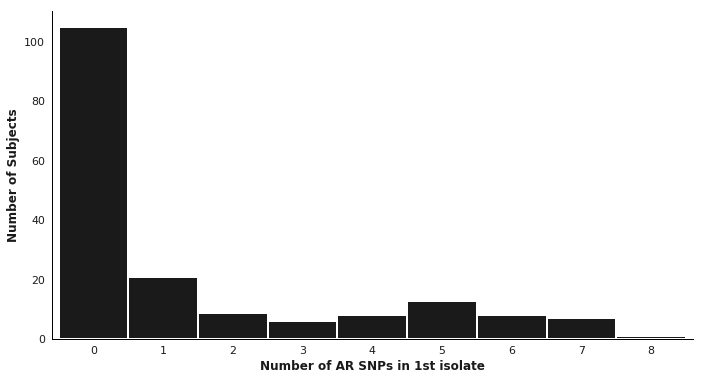

In [158]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(AR_SNPs_in_1st_isolate_per_subject , rwidth = 1.0 , edgecolor='white', bins =  range(0 , max(AR_SNPs_in_1st_isolate_per_subject) + 2) , linewidth = 2.0 , color = 'k' , align = 'left')

plt.ylabel('Number of Subjects', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Number of AR SNPs in 1st isolate', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks(range(0 , max(AR_SNPs_in_1st_isolate_per_subject) + 1 , 1)) #xtick positions
ax.set_xticklabels([str(x) for x in range(0 , max(AR_SNPs_in_1st_isolate_per_subject) + 1 , 1)]) #xtick labels

ax.tick_params(labelcolor = 'k')
ax.tick_params(direction='out', length=3, width=1.25, colors='k') #make tick marks darker

ax.set_xlim(-0.6 , max(AR_SNPs_in_1st_isolate_per_subject) + 0.6)

fig = plt.gcf()
fig.set_size_inches(10.0, 5.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/antibiotic_resistance_analysis/number_AR_SNPs_in_1st_isolate_failure_relapse_subjects.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### SNPs most represented in 1st collected isolate

In [159]:
pd.Series( Counter( all_AR_SNPS_1st_sample_df.ref_position ) ).sort_values(ascending = False).head(n = 20)

2155168.0    37
761155.0     31
1673425.0    19
2518919.0    15
4247431.0    14
4242182.0     8
409569.0      7
4407967.0     6
7582.0        6
761110.0      6
4247429.0     6
1674481.0     5
4247730.0     5
4247729.0     5
781687.0      5
781822.0      4
4326116.0     4
1472359.0     3
1674263.0     3
2289090.0     3
dtype: int64

#### Find out how many subjects had MDR TB for the 1st collected isolate

In [160]:
patients_with_MDR = []

for patient_id in patients_to_keep:
    
    RIF_res = False
    INH_res = False
    
    #subset to AR SNPs detected in 1st collected isolate
    all_AR_SNPS_1st_sample_df_for_patient = all_AR_SNPS_1st_sample_df[all_AR_SNPS_1st_sample_df.patient_id == patient_id]
    
    #create list of Ref Positions + Alternate Allele
    all_AR_SNPS_1st_sample_for_patient = [str(int(ref_pos)) + '_' + alt_allele for ref_pos, alt_allele in zip(all_AR_SNPS_1st_sample_df_for_patient.ref_position , all_AR_SNPS_1st_sample_df_for_patient.alt_base)]
    
    #check for SNP assoc. with RIF & INH resistance
    for AR_SNP in all_AR_SNPS_1st_sample_for_patient:
        
        if AR_SNP in AR_RIF_variants:
            
            RIF_res = True
            
        elif AR_SNP in AR_INH_variants:
            
            INH_res = True
            
    #store patient in list of the patient has at least 1 RIF SNP and 1 INH SNP in 1st collected isolate
    if ((RIF_res == True) and (INH_res == True)):
        
        patients_with_MDR.append(patient_id)

In [161]:
print patients_with_MDR

['P316', 'P367', '1672', '1673', '1700', '1719', '1827', '1846', '1948', '1960', '2026', '2307', '2319', '2436', '2491', '2523', '2556', '2688', '2918', '2968', '3451', '3673', 'I0000024-5', 'I0000068-2', 'I0000180-5', 'I0001112-7', 'I0001162-2', 'I0001560-7', 'I0002457-5', 'I0002615-8', 'I0002960-8', 'I0003165-3', 'I0003398-0', 'I0004013-4', 'I0004236-1', 'I0004746-9', 'I0005229-5', 'I0005235-2', 'I0005973-8', 'P08', 'P09', 'P10', 'P11', 'P000155', 'P000225', 'P000226', 'D']


In [162]:
len(patients_with_MDR)

47

In [163]:
len(patients_to_keep)

178

In [164]:
print 'Proportion of Subjects with MDR TB = ' + str(float(len(patients_with_MDR)) / float(len(patients_to_keep)))

Proportion of Subjects with MDR TB = 0.26404494382


### Get the number of AR SNPs that cropped up between longitudinal isolates (with $AF \ge 40\%$) from subjects with treatment failure

In [165]:
AR_SNPs_between_isolates_per_subject = pd.Series()
for subject_id in list(AR_SNPs_in_1st_isolate_per_subject.index):
    AR_SNPs_between_isolates_per_subject[subject_id] = np.sum(all_SNPs_within_patients_AR_fSNPs.patient_id == subject_id)

In [166]:
AR_SNPs_between_isolates_per_subject.head()

1672    0
1673    0
1700    2
1719    0
1827    0
dtype: int64

In [167]:
len(AR_SNPs_between_isolates_per_subject)

178

### Test for association between pre-existing AR & AR SNP acquisition in *failure* subjects

#### Split subjects into 2 groups, subjects with no AR SNPs in 1st isolate (Group B1) & subjects with at least 1 AR SNP in 1st isolate (Group B2)

In [168]:
group_B1_subjects = list( AR_SNPs_in_1st_isolate_per_subject[AR_SNPs_in_1st_isolate_per_subject == 0].index )
group_B2_subjects = list( AR_SNPs_in_1st_isolate_per_subject[AR_SNPs_in_1st_isolate_per_subject > 0].index )

In [169]:
len(group_B1_subjects)

105

In [170]:
len(group_B2_subjects)

73

#### Group B1

Subjects with no AR SNPs in 1st collected longitudinal sample who also had no AR SNPs crop up between isolate collection

In [171]:
sum( AR_SNPs_between_isolates_per_subject[group_B1_subjects] == 0 )

98

Subjects with no AR SNPs in 1st collected longitudinal sample who also had at least 1 AR SNP crop up between isolate collection

In [172]:
sum( AR_SNPs_between_isolates_per_subject[group_B1_subjects] > 0 )

7

In [173]:
float(7) / float(105)

0.06666666666666667

#### Group B2

Subjects who had at least 1st collected longitudinal sample who also had no AR SNPs crop up between isolate collection

In [174]:
sum( AR_SNPs_between_isolates_per_subject[group_B2_subjects] == 0 )

53

Subjects who had at least 1st collected longitudinal sample who also had at least 1 AR SNP crop up between isolate collection

In [175]:
sum( AR_SNPs_between_isolates_per_subject[group_B2_subjects] > 0 )

20

In [176]:
float(20) / float(73)

0.273972602739726

#### Fisher exact test to test independence

In [177]:
AR_SNP_cont_table = np.array([[98,7] , [53,20]])

In [178]:
AR_SNP_cont_table

array([[98,  7],
       [53, 20]])

In [179]:
oddsratio, pvalue = stats.fisher_exact(AR_SNP_cont_table) #rows: (1) subjects with no AR SNPs in 1st isolate (2) subjects with at least 1 AR SNP in 1st isolate ; columns: (1) no AR SNPs between isolate collection (2) at least 1 AR SNP between isolate collection

In [180]:
oddsratio

5.283018867924528

In [181]:
pvalue

0.00021986311590681707

### Further analysis on *B2* group that acquired an AR SNP between sample collection

- $\frac{27}{178} \approx 15\%$ treatment failure subjects had an AR fSNP between sampling 

- $\frac{20}{27} \approx 74\%$ of cases of AR fSNP acquisition (e.g. *Resistance Amplification*) occurred in the **B2** group (isolates genotypically resistant at the outset).

- Of the $\frac{20}{27} \approx 74\%$ subjects, how many developed an AR fSNP that resulted in a resistance mutation to an **additional** drug, the acqusition of an AR fSNP that incurs resistance to a drug for which no resistance mutations were detected at the outset?

Get the subject IDs for subjects that: 
1. Had sample collections time $\ge 2$ months (classified as treatment failure)
2. Were genotypically resistant at the outset ($\ge 1$ pAR SNP detected in 1st isolate)
3. Developed Resistance Amplification ($\ge 1$ AR fSNP between sample collection)

In [182]:
subjects_treatment_failure_AND_genotypically_resistant_outset_AND_AR_fSNP_acquisition = AR_SNPs_between_isolates_per_subject[group_B2_subjects][AR_SNPs_between_isolates_per_subject[group_B2_subjects] > 0]

In [183]:
len(subjects_treatment_failure_AND_genotypically_resistant_outset_AND_AR_fSNP_acquisition)

20

Annotation for Antibiotic Resistance Loci

In [184]:
H37Rv_regions_of_interest = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/H37Rv_AR_regions_of_interest.csv' , sep = ',').set_index('Unnamed: 0')
H37Rv_regions_of_interest.index.rename('' , inplace = True)

In [185]:
H37Rv_regions_of_interest.head()

,H37Rv_start,H37Rv_end,type,gene_after,gene_before,symbol,description
,,,,,,,
0,5239,7267,gene,Rv0005,Rv0005,gyrB,DNA gyrase subunit B
1,7301,9818,gene,Rv0006,Rv0006,gyrA,DNA gyrase subunit A
2,409361,410801,gene,Rv0341,Rv0341,iniB,isoniazid inductible gene protein
3,410837,412760,gene,Rv0342,Rv0342,iniA,isoniazid inductible gene protein
4,412756,414238,gene,Rv0343,Rv0343,iniC,isoniazid inductible gene protein


#### Collect all H37Rv locus tags with (AR SNPs at the outset) or (AR SNPs acquired between sampling) 

In [186]:
gene_locus_tag_list = []

for subject_id in subjects_treatment_failure_AND_genotypically_resistant_outset_AND_AR_fSNP_acquisition.index:
    
    #collect genes with SNPs for this subject
    genes_with_resistance_SNPs_outset_subject_i = list(set(all_AR_SNPS_1st_sample_df[all_AR_SNPS_1st_sample_df.patient_id == subject_id].gene_id)) #genes with SNPs at outset
    genes_with_resistance_SNPs_acquired_subject_i = list(set(all_SNPs_within_patients_AR_fSNPs[all_SNPs_within_patients_AR_fSNPs.patient_id == subject_id].gene_id)) #genes with SNPs acquired between samples
    
    #get genes with AR SNPs at outset across subset of subjects
    for gene_locus_tag in genes_with_resistance_SNPs_outset_subject_i:
        gene_locus_tag_list.append(gene_locus_tag)
    
    #get genes with AR SNPs acquired across subset of subjects
    for gene_locus_tag in genes_with_resistance_SNPs_acquired_subject_i:
        gene_locus_tag_list.append(gene_locus_tag)
        
gene_locus_tag_list = list(set(gene_locus_tag_list))

In [187]:
print gene_locus_tag_list

['Rv0006', 'Rv0341', 'Rv0005', 'Rv3793_Rv3794', 'Rv0682', 'Rv3854c', 'Rv2043c', 'Rv3806c', 'Rv3795', 'Rv3794', 'Rv3793', 'Rv0668', 'Rv1694', 'Rv1908c', 'Rv1484', 'Rv2447c', 'Rv3919c', 'Rv2245', 'Rv0667', 'Rv1482c_Rv1483']


Create a dictionary that contains the symbol for each locus tag

In [188]:
gene_locus_tag_symbol_dict = {
'Rv0006':'gyrA', 
'Rv0341':'iniB', 
'Rv0005':'gyrB', 
'Rv3793_Rv3794':'promoter_embA-embB', 
'Rv0682':'rpsL', 
'Rv3854c':'ethA', 
'Rv2043c':'pncA', 
'Rv3806c':'ubiA', 
'Rv3795':'embB', 
'Rv3794':'embA', 
'Rv3793':'embC', 
'Rv0668':'rpoC', 
'Rv1694':'tlyA', 
'Rv1908c':'katG', 
'Rv1484':'inhA', 
'Rv2447c':'folC', 
'Rv3919c':'gid', 
'Rv2245':'kasA', 
'Rv0667':'rpoB', 
'Rv1482c_Rv1483':'promoter_fabG1-inhA'
}

#### Collect all locus symbols with (AR SNPs at the outset) or (AR SNPs acquired between sampling) for each subject

In [189]:
genes_with_resistance_SNPs_outset = []
genes_with_resistance_SNPs_acquired = []

for subject_id in subjects_treatment_failure_AND_genotypically_resistant_outset_AND_AR_fSNP_acquisition.index:
    
    #collect genes with SNPs for this subject
    genes_with_resistance_SNPs_outset_subject_i = list(set(all_AR_SNPS_1st_sample_df[all_AR_SNPS_1st_sample_df.patient_id == subject_id].gene_id)) #genes with SNPs at outset
    genes_with_resistance_SNPs_acquired_subject_i = list(set(all_SNPs_within_patients_AR_fSNPs[all_SNPs_within_patients_AR_fSNPs.patient_id == subject_id].gene_id)) #genes with SNPs acquired between samples
    
    #get symbols for genes
    gene_symbols_with_resistance_SNPs_outset_subject_i = []
    for gene_locus_tag in genes_with_resistance_SNPs_outset_subject_i:
        
        gene_symbols_with_resistance_SNPs_outset_subject_i.append(gene_locus_tag_symbol_dict[gene_locus_tag])
            
    gene_symbols_with_resistance_SNPs_acquired_subject_i = []
    for gene_locus_tag in genes_with_resistance_SNPs_acquired_subject_i:
        
        gene_symbols_with_resistance_SNPs_acquired_subject_i.append(gene_locus_tag_symbol_dict[gene_locus_tag])
    
    #store gene symbols for genes with pre-existing AR SNPs & acquired AR SNPs     
    genes_with_resistance_SNPs_outset.append(gene_symbols_with_resistance_SNPs_outset_subject_i)
    genes_with_resistance_SNPs_acquired.append(gene_symbols_with_resistance_SNPs_acquired_subject_i)
    
#create DataFrame
treatment_failure_AR_pSNP_fSNP_subjects_genes = pd.DataFrame(index = subjects_treatment_failure_AND_genotypically_resistant_outset_AND_AR_fSNP_acquisition.index)
treatment_failure_AR_pSNP_fSNP_subjects_genes['genes with AR pSNPs'] = genes_with_resistance_SNPs_outset
treatment_failure_AR_pSNP_fSNP_subjects_genes['genes with AR fSNPs'] = genes_with_resistance_SNPs_acquired

In [190]:
treatment_failure_AR_pSNP_fSNP_subjects_genes

,genes with AR pSNPs,genes with AR fSNPs
1700,"[embB, pncA, rpoB, inhA]",[katG]
1846,"[pncA, embB, embA, embC, kasA, rpoB]",[gyrA]
1960,"[iniB, katG, gid, rpoB, embB]",[gyrA]
1972,"[pncA, embB, embC, katG, promoter_fabG1-inhA, ...","[gyrA, tlyA]"
2307,"[gyrA, katG, embB, rpoB, pncA]","[promoter_fabG1-inhA, ethA]"
2511,[katG],[rpoB]
2523,"[ethA, pncA, embB, inhA, kasA, rpoB]",[gyrA]
2688,"[pncA, embB, embC, inhA, gid, kasA, rpoB, prom...",[rpoC]
2968,"[embB, rpoB]",[ubiA]
3451,"[embB, pncA, rpoB, inhA]","[gyrA, pncA]"


In [191]:
for subject_id in treatment_failure_AR_pSNP_fSNP_subjects_genes.index:
    
    print subject_id
    print treatment_failure_AR_pSNP_fSNP_subjects_genes.loc[subject_id , 'genes with AR pSNPs']
    print treatment_failure_AR_pSNP_fSNP_subjects_genes.loc[subject_id , 'genes with AR fSNPs']
    print ''

1700
['embB', 'pncA', 'rpoB', 'inhA']
['katG']

1846
['pncA', 'embB', 'embA', 'embC', 'kasA', 'rpoB']
['gyrA']

1960
['iniB', 'katG', 'gid', 'rpoB', 'embB']
['gyrA']

1972
['pncA', 'embB', 'embC', 'katG', 'promoter_fabG1-inhA', 'kasA', 'rpoB']
['gyrA', 'tlyA']

2307
['gyrA', 'katG', 'embB', 'rpoB', 'pncA']
['promoter_fabG1-inhA', 'ethA']

2511
['katG']
['rpoB']

2523
['ethA', 'pncA', 'embB', 'inhA', 'kasA', 'rpoB']
['gyrA']

2688
['pncA', 'embB', 'embC', 'inhA', 'gid', 'kasA', 'rpoB', 'promoter_fabG1-inhA']
['rpoC']

2968
['embB', 'rpoB']
['ubiA']

3451
['embB', 'pncA', 'rpoB', 'inhA']
['gyrA', 'pncA']

3673
['pncA', 'embC', 'inhA', 'gid', 'kasA', 'rpoB', 'promoter_fabG1-inhA']
['embB']

D
['gyrA', 'embB', 'rpsL', 'pncA', 'katG', 'rpoB']
['folC']

I0000024-5
['pncA', 'embB', 'embA', 'embC', 'katG', 'kasA', 'rpoB']
['gyrB']

KPS_5
['katG']
['embB']

P000071
['rpoB']
['promoter_embA-embB', 'gid']

P000155
['katG', 'rpoB', 'embB']
['gyrA']

P000226
['gyrA', 'embB', 'rpoB']
['katG']

P052


#### Subjects above that developed resistance to an *additional* antibiotic

**1700** -
- pAR SNPs in genes = embB, pncA, rpoB, inhA
- AR fSNP in genes = katG

**1846** +
- pAR SNPs in genes = pncA, embB, embA, embC, kasA, rpoB
- AR fSNP in genes = gyrA

**1960** +
- pAR SNPs in genes = iniB, katG, gid, rpoB, embB
- AR fSNP in genes = gyrA

**1972** +
- pAR SNPs in genes = pncA, embB, embC, katG, promoter_fabG1-inhA, kasA, rpoB
- AR fSNP in genes = gyrA, tlyA

**2307** +
- pAR SNPs in genes = gyrA, katG, embB, rpoB, pncA
- AR fSNP in genes = promoter_fabG1-inhA, ethA

**2511** +
- pAR SNPs in genes = katG
- AR fSNP in genes = rpoB

**2523** +
- pAR SNPs in genes = ethA, pncA, embB, inhA, kasA, rpoB
- AR fSNP in genes = gyrA

**2688** -
- pAR SNPs in genes = pncA, embB, embC, inhA, gid, kasA, rpoB, promoter_fabG1-inhA
- AR fSNP in genes = rpoC

**2968** -
- pAR SNPs in genes = embB, rpoB
- AR fSNP in genes = ubiA

**3451** +
- pAR SNPs in genes = embB, pncA, rpoB, inhA
- AR fSNP in genes = gyrA, pncA

**3673** -
- pAR SNPs in genes = pncA, embC, inhA, gid, kasA, rpoB, promoter_fabG1-inhA
- AR fSNP in genes = embB

**D** +
- pAR SNPs in genes = gyrA, embB, rpsL, pncA, katG, rpoB
- AR fSNP in genes = folC

**I0000024-5** +
- pAR SNPs in genes = pncA, embB, embA, embC, katG, kasA, rpoB
- AR fSNP in genes = gyrB

**KPS_5** +
- pAR SNPs in genes = katG
- AR fSNP in genes = embB

**P000071** +
- pAR SNPs in genes = rpoB
- AR fSNP in genes = promoter_embA-embB, gid

**P000155** +
- pAR SNPs in genes = katG, rpoB, embB
- AR fSNP in genes = gyrA

**P000226** +
- pAR SNPs in genes = gyrA, embB, rpoB
- AR fSNP in genes = katG

**P052** +
- pAR SNPs in genes = promoter_fabG1-inhA
- AR fSNP in genes = rpoC, rpoB

**P10** +
- pAR SNPs in genes = rpsL, embB, rpoB, promoter_fabG1-inhA
- AR fSNP in genes = gyrA

**P251** +
- pAR SNPs in genes = promoter_fabG1-inhA
- AR fSNP in genes = rpoB

#### Of the $\frac{27}{178} \approx 15\%$ of subjects that developed an AR fSNP between sampling, $\frac{16}{27} \approx 59\%$ occurred among subjects that had at least 1pAR SNP and resulted in acquisition of an AR fSNP to an addtional antiobiotic (for which there were not AR mutations in the first isolate).

### Test for association between pre-existing MDR & AR SNP acquisition in *failure* subjects

#### Split subjects into 2 groups, subjects without MDR in 1st isolate (Group C1) & subjects with MDR in 1st isolate (Group C2)

In [192]:
group_C1_subjects = set(patients_to_keep) - set(patients_with_MDR)
group_C2_subjects = patients_with_MDR

In [193]:
len(group_C1_subjects)

131

In [194]:
len(group_C2_subjects)

47

#### Group C1

Subjects without MDR in 1st collected longitudinal sample who also had no AR SNPs crop up between isolate collection

In [195]:
sum( AR_SNPs_between_isolates_per_subject[group_C1_subjects] == 0 )

118

Subjects without MDR in 1st collected longitudinal sample who also had at least 1 AR SNP crop up between isolate collection

In [196]:
sum( AR_SNPs_between_isolates_per_subject[group_C1_subjects] > 0 )

13

In [201]:
float(13) / float(131)

0.09923664122137404

#### Group C2

Subjects who had MDR in 1st collected longitudinal sample who also had no AR SNPs crop up between isolate collection

In [198]:
sum( AR_SNPs_between_isolates_per_subject[group_C2_subjects] == 0 )

33

Subjects who had MDR in 1st collected longitudinal sample who also had at least 1 AR SNP crop up between isolate collection

In [199]:
sum( AR_SNPs_between_isolates_per_subject[group_C2_subjects] > 0 )

14

In [202]:
float(14) / float(47)

0.2978723404255319

#### Fisher exact test to test independence

In [203]:
AR_SNP_cont_table = np.array([[118,13] , [33,14]])

In [204]:
AR_SNP_cont_table

array([[118,  13],
       [ 33,  14]])

In [205]:
oddsratio, pvalue = stats.fisher_exact(AR_SNP_cont_table) #rows: (1) subjects without MDR in 1st isolate (2) subjects with MDR in 1st isolate ; columns: (1) no AR SNPs between isolate collection (2) at least 1 AR SNP between isolate collection

In [206]:
oddsratio

3.850815850815851

In [207]:
pvalue

0.003429044117798598